# Filtration Analysis of Gold Price Time Series
### Project Name: Metalytics
### Sum25 / Capstone Project | Innopolis University
### Author: @DavidVista
This notebook explores datasets for future machine training and evaluation by visual and statistical analysis. Hypothesis testing is proposed to study volatility of the metal, and filtration techniques are tested out to improve the quality of datasets. The primary goal of the project is to propose and design a ML model for short-term predictions of the gold price on the Russian market. However, due to lack of data availability, the suggested approach is to analyze American market and build a model upon these data by providing enough evidence about similarity of the markets distributions over short time periods.

#### Plan:
1. Present Datasets.
2. Time Series Properties of Datasets.
3. Distribution Similarity Analysis.
4. Regression Models.
5. Forecasting Framework.
6. Filter Design Approaches.
7. Filtration tests.
8. Results.
9. Conclusion.

## 0. Necessary Dependencies

In [468]:
import numpy as np
import pandas as pd
import ta
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
from numpy.lib.stride_tricks import sliding_window_view
from typing import Tuple, Dict, List
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.api import OLS, add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator
from abc import ABC, abstractmethod
import joblib
import os

# 1. Present Datasets

In this chapter, I present the proposed datasets for analysis of gold price time series. The datasets are chosen from open-access web sources and cited properly. The choice of datasets is justified, and usability of each is explained.

- The first dataset is a subset of the excel table presented by World Gold Council through the website https://www.gold.org/goldhub/data/gold-prices, which consists of the gold price averages over a range of timeframes (monthly, quarterly, annually) going back to 1978, and in the major trading, producer, and consumer currencies. The dataset was sourced from the ICE Benchmark Administration, provided by FactSet Research Systems Inc. First, since the primary goal of the project is to build a model predicting price on the short period of time, only monthly ranged data is selected. Next, out of presented currencies, only 5 were selected to analyze several distinct markets across the globe. Specifically, the following currencies were selected: USD, EUR, JPY, CNY, RUB.
- The second dataset is captured through the open-access Python package `yfinance` and incorporates gold futures market prices in the US during the period of 730 days from June 2024. This period is sampled hourly resulting in more detailed view on the daily changes of the market. Since futures market is more relevant for short-term prediction model, the dataset will be primarily used for the analysis and model selection. For the project purposes, this dataset was additionally augmented by the following indicators: EMA20, RSI14, ATR14, MACD, MACD_Signal, MACD_Hist.

## Visual Analysis

### Currency Gold Dataset

In [7]:
dataset_gold = pd.read_csv("data/gold.csv", parse_dates=[0], index_col=0)

In [8]:
dataset_gold.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400 entries, 1992-02-28 to 2025-05-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   USD     400 non-null    object
 1   EUR     400 non-null    object
 2   JPY     400 non-null    object
 3   CNY     400 non-null    object
 4   RUB     400 non-null    object
dtypes: object(5)
memory usage: 18.8+ KB


In [9]:
# Optimize data types
currencies = ['USD', 'EUR', 'JPY', 'CNY', 'RUB']
dataset_gold[currencies] = dataset_gold[currencies].apply(lambda series : series.str.replace(',', '.').str.replace('\xa0', '').astype('float64'))
dataset_gold.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400 entries, 1992-02-28 to 2025-05-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USD     400 non-null    float64
 1   EUR     400 non-null    float64
 2   JPY     400 non-null    float64
 3   CNY     400 non-null    float64
 4   RUB     400 non-null    float64
dtypes: float64(5)
memory usage: 18.8 KB


In [10]:
dataset_gold.head()

,USD,EUR,JPY,CNY,RUB
Date,,,,,
1992-02-28,329.0,263.3,41124.1,1890.4,148.4
1992-03-31,329.3,270.2,39751.4,1922.4,188.4
1992-04-30,330.1,273.1,38614.5,1882.6,209.0
1992-05-29,342.2,273.9,38423.8,1934.2,249.4
1992-06-30,367.2,294.5,40488.1,2112.1,317.8


Let's plot time (in years) versus price

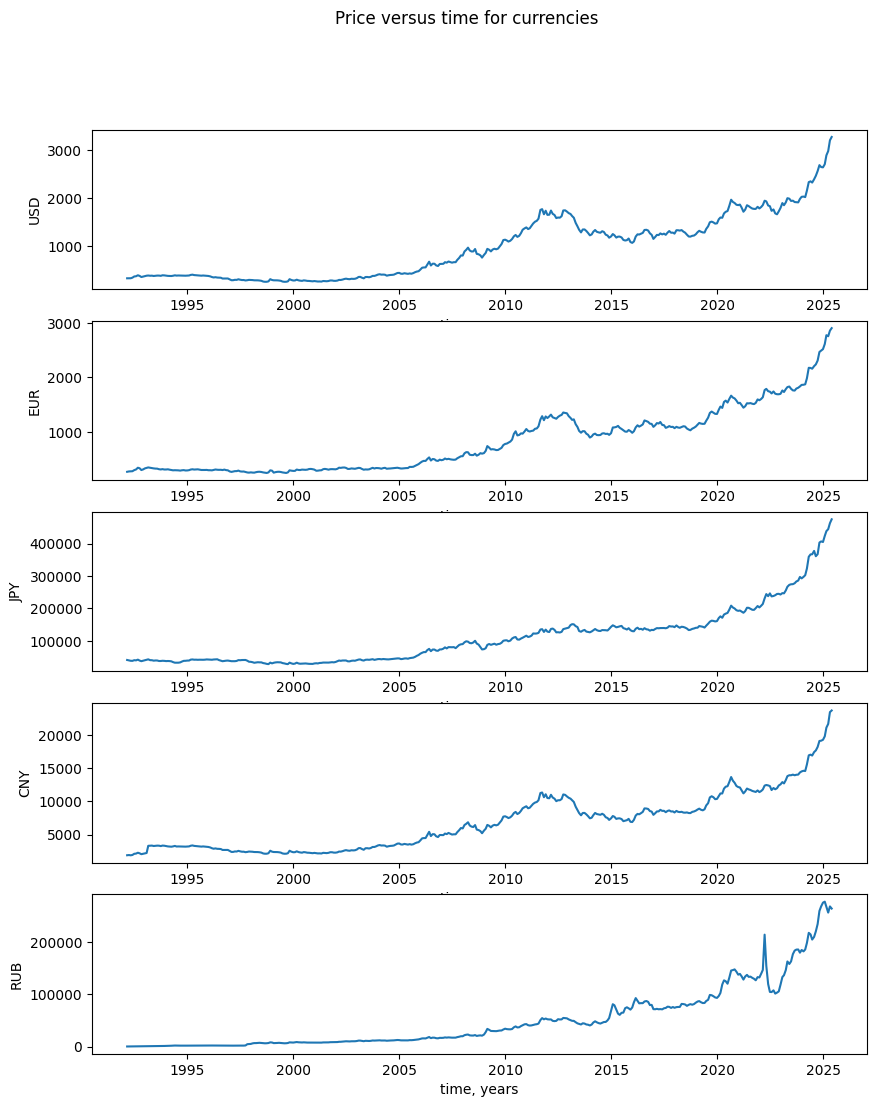

In [6]:
fig, ax = plt.subplots(nrows=5, figsize=(10, 12))
fig.suptitle("Price versus time for currencies")

for idx, currency in enumerate(currencies):
    ax[idx].plot(dataset_gold.index, dataset_gold[currency])
    ax[idx].xaxis.set_major_locator(YearLocator(5))
    ax[idx].set_ylabel(currency)
    ax[idx].set_xlabel(f'time, years')

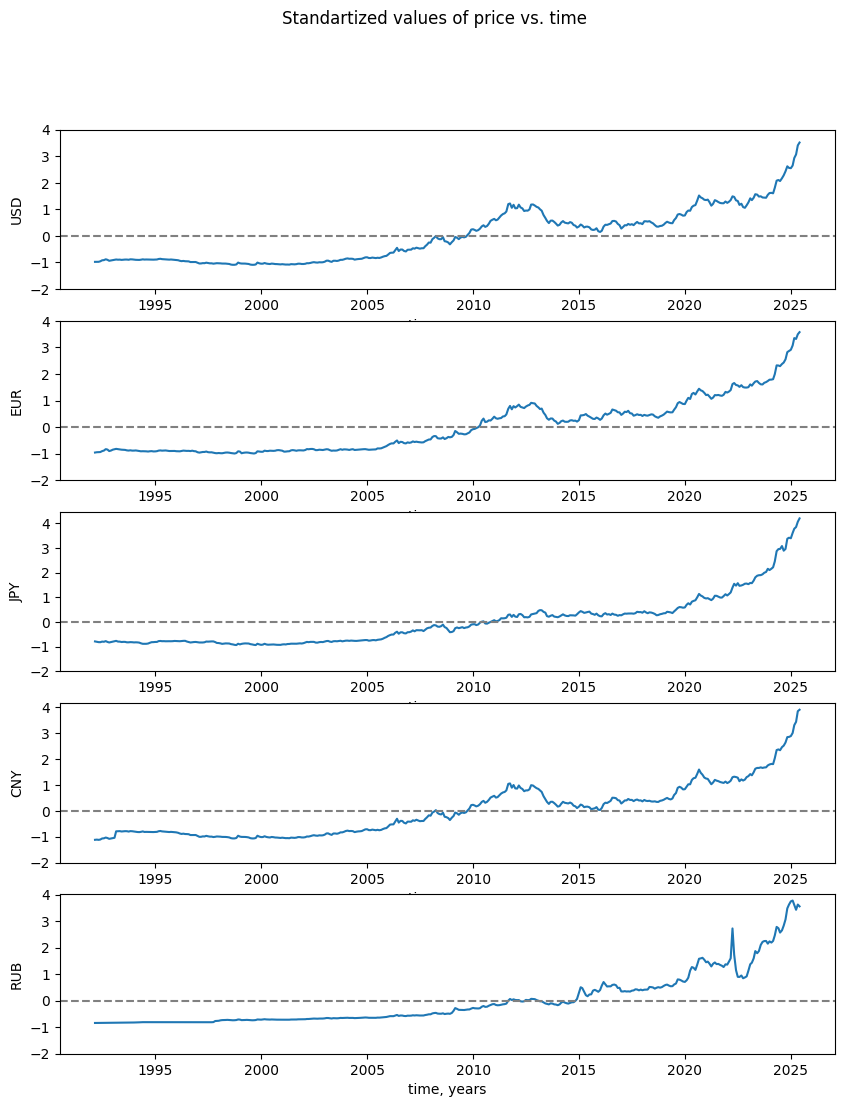

In [7]:
fig, ax = plt.subplots(nrows=5, figsize=(10, 12))
fig.suptitle("Standartized values of price vs. time")

for idx, currency in enumerate(currencies):
    ax[idx].plot(dataset_gold.index, (dataset_gold[currency] - dataset_gold[currency].mean()) / dataset_gold[currency].std())
    ax[idx].axhline(0, linestyle='--', color='grey')
    ax[idx].xaxis.set_major_locator(YearLocator(5))
    ax[idx].set_yticks(np.arange(-2, 5, 1))
    ax[idx].set_ylabel(currency)
    ax[idx].set_xlabel(f'time, years')

#### General Conclusions

1. All plots suggest non-stationarity of time series due to the visible trend of increasing mean.
2. Local trends of all currencies are distinct implying the distinct behavior of markets to global events.
3. Overall trend is the same across selected markets: growth with minor fluctuations.
4. The most similar markets are USD, EUR, CNY. While JPY and RUB follow different patterns compared to the rest and each other.

### American Futures Gold Market

In [3]:
dataset_us_aug = pd.read_csv("data/gold_futures_with_indicators.csv", parse_dates=[0], index_col=0)

In [4]:
dataset_us_aug.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11468 entries, 2023-06-11 22:00:00+00:00 to 2025-06-10 00:00:00+00:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        11468 non-null  float64
 1   High         11468 non-null  float64
 2   Low          11468 non-null  float64
 3   Open         11468 non-null  float64
 4   Volume       11468 non-null  int64  
 5   EMA20        11448 non-null  float64
 6   RSI14        11454 non-null  float64
 7   ATR14        11468 non-null  float64
 8   MACD         11442 non-null  float64
 9   MACD_Signal  11434 non-null  float64
 10  MACD_Hist    11434 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 1.0 MB


In [13]:
dataset_us_aug.head()

,Close,High,Low,Open,Volume,EMA20,RSI14,ATR14,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,,,
2023-06-11 22:00:00+00:00,1973.400024,1975.800049,1973.199951,1975.599976,937,NaN,NaN,0.0,NaN,NaN,NaN
2023-06-11 23:00:00+00:00,1974.300049,1975.099976,1972.500000,1973.400024,1182,NaN,NaN,0.0,NaN,NaN,NaN
2023-06-12 00:00:00+00:00,1972.699951,1974.900024,1972.400024,1974.300049,1453,NaN,NaN,0.0,NaN,NaN,NaN
2023-06-12 01:00:00+00:00,1970.199951,1973.900024,1969.699951,1972.699951,3860,NaN,NaN,0.0,NaN,NaN,NaN
2023-06-12 02:00:00+00:00,1970.199951,1970.599976,1968.400024,1970.099976,2835,NaN,NaN,0.0,NaN,NaN,NaN


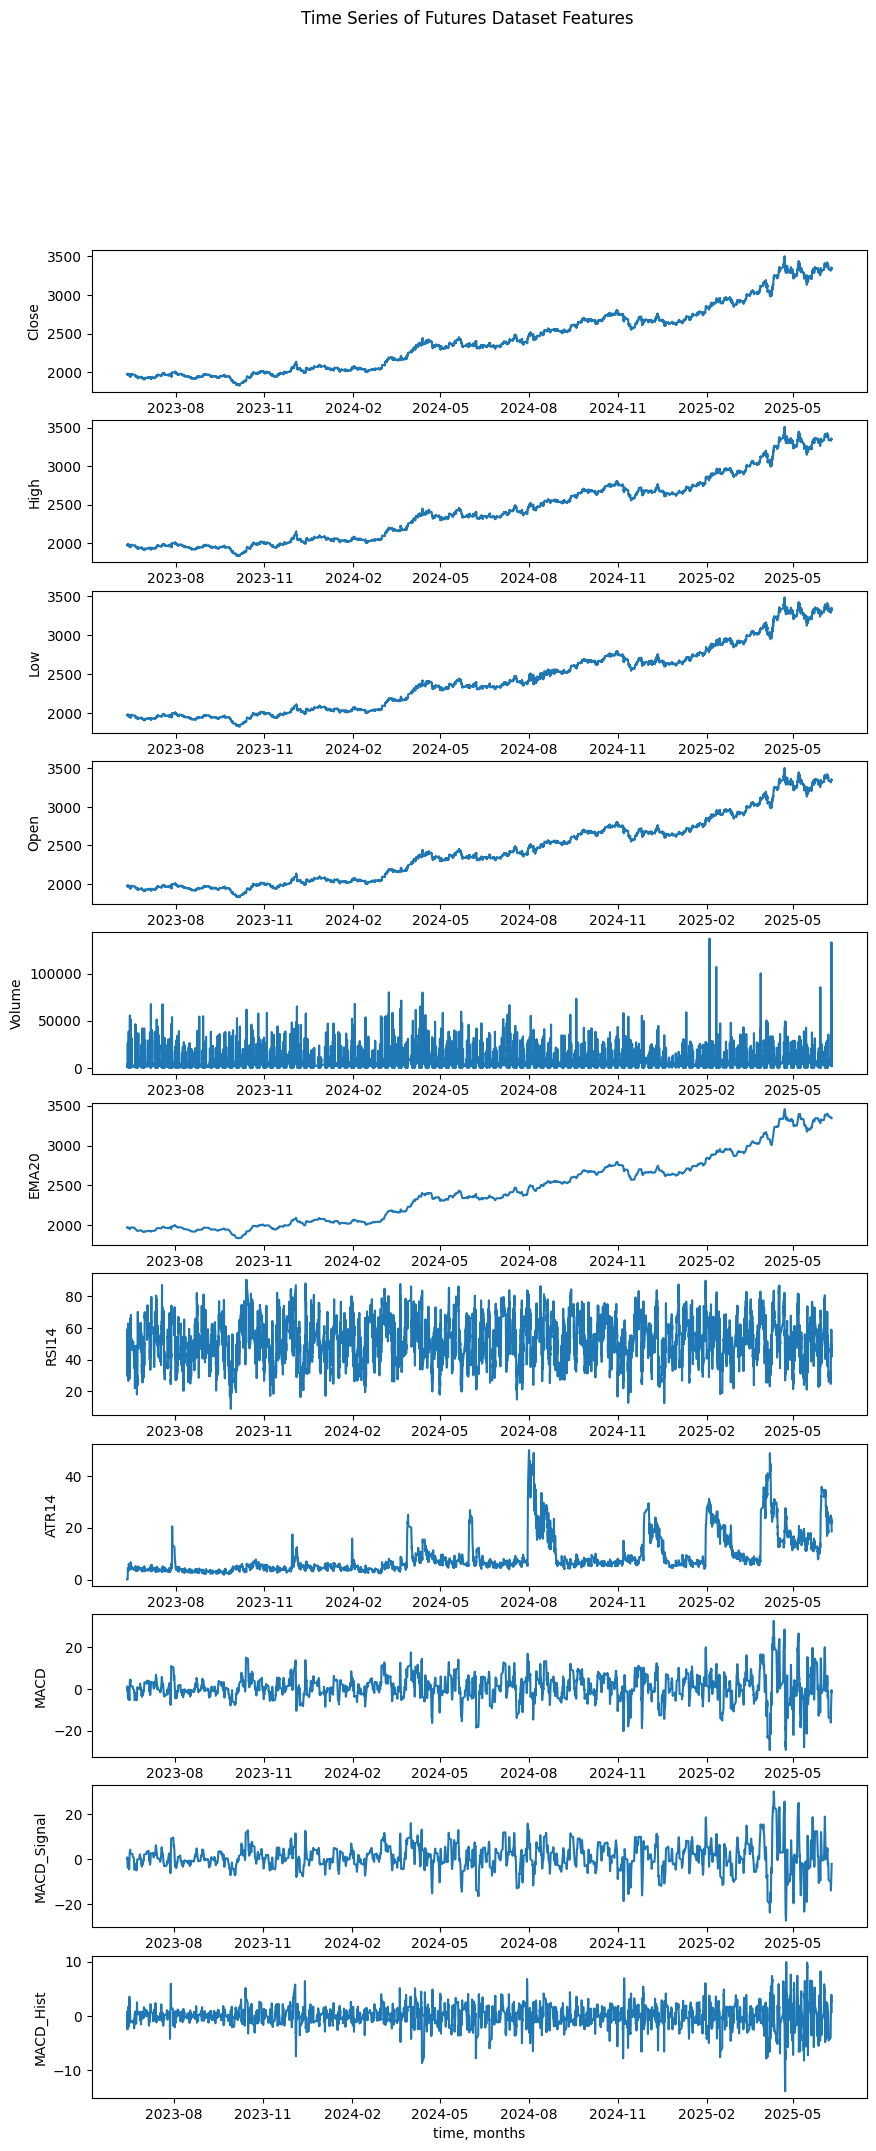

In [11]:
columns = dataset_us_aug.columns

fig, ax = plt.subplots(nrows=len(columns), figsize=(10, 24))
fig.suptitle("Time Series of Futures Dataset Features")

for idx, feature in enumerate(columns):
    ax[idx].plot(dataset_us_aug.index, dataset_us_aug[feature])
    ax[idx].xaxis.set_major_locator(MonthLocator(interval=3))
    ax[idx].set_ylabel(feature)
    ax[idx].set_xlabel(f'time, months')

#### Price Features Analysis

First, study how close price deviates from the open, high, and low price series.

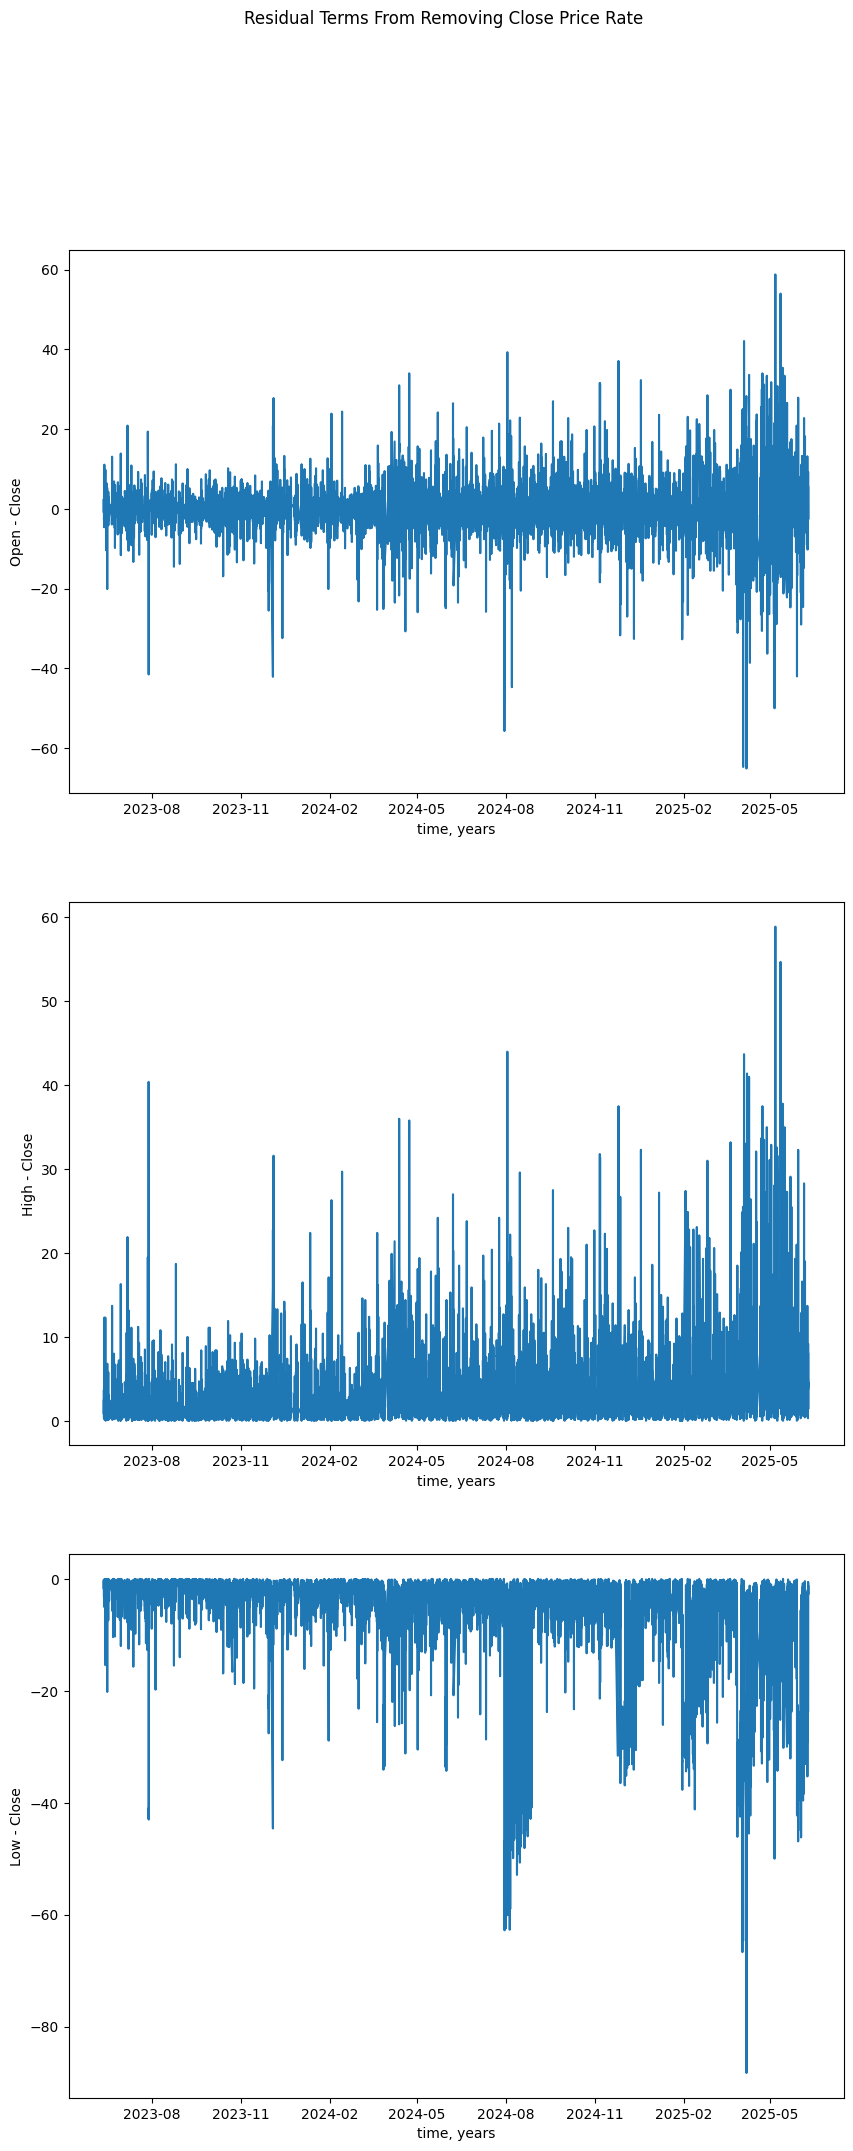

In [12]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 24))
fig.suptitle("Residual Terms From Removing Close Price Rate")

for idx, feature in enumerate(['Open', 'High', 'Low']):
    ax[idx].plot(dataset_us_aug.index, dataset_us_aug[feature] - dataset_us_aug['Close'])
    ax[idx].xaxis.set_major_locator(MonthLocator(interval=3))
    ax[idx].set_ylabel(f"{feature} - Close")
    ax[idx].set_xlabel(f'time, years')

##### Open-Close Case Analysis
Given the graph of the residual term, we can formulate the following hypothesis:

$H_0$: mean is zero.

Conduct one sample t-test:

In [13]:
residual_open_close = dataset_us_aug['Open'] - dataset_us_aug['Close']

In [14]:
from scipy.stats import ttest_1samp
t_stat, p_value = ttest_1samp(residual_open_close, 0)
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

t-statistic: -3.5347, p-value: 0.0004


Since $p$-value is less than $0.05$, **mean is said to be zero**.

Now, consider the following constraint on the residual time series:

$H_0$: Open - Close time series is a white noise.

Conduct Regression, Ljunc-Box, and Durbin-Watson tests.

1. Regression model: $Y_t = \beta X_t + \alpha + \varepsilon_t$, where $X_t$ is the open price, $Y_t$ is the close price, $\beta \approx 1$, $\alpha \approx 0$, $\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$.

Split the original hypothesis into smaller ones:

$H_0$: $\beta = 1$

$H_0$: $\alpha = 0$

$H_0$: $\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$

In [15]:
X = add_constant(dataset_us_aug['Open'])
Y = dataset_us_aug['Close']
model = OLS(Y, X)
results = model.fit()
print(results.params)

# Test \beta = 1 and \alpha = 0
print(results.t_test("Open = 1, const = 0"))

const   -0.171869
Open     1.000145
dtype: float64
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0001      0.000      1.227      0.220       1.000       1.000
c1            -0.1719      0.291     -0.590      0.555      -0.743       0.399


Error mean: 1.8048727261029213e-12


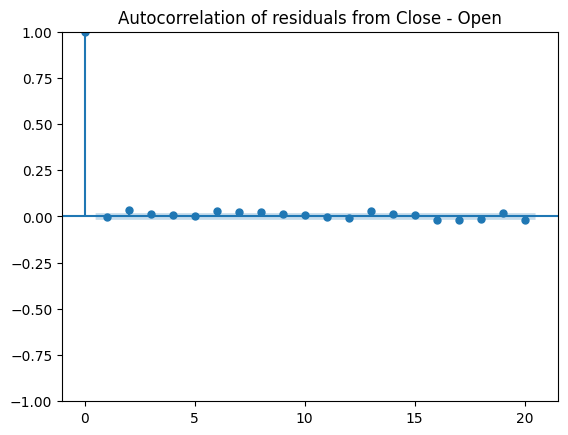

In [16]:
# Check residuals
residuals = results.resid
print(f"Error mean: {results.resid.mean()}")
_ = plot_acf(residuals, lags=20, title="Autocorrelation of residuals from Close - Open")

The results of the fit regression model suggest the following:
1. Not enough statistical evidence ($p$-value $= 0.220$) to reject hypothesis $\beta = 1$.
2. Not enough statistical evidence ($p$-value $= 0.555$) to reject hypothesis $\alpha = 0$.
3. The error term series does not experience autocorrelation, which implies its normal distribution nature.

2. Ljunc-Box, and Durbin-Watson tests

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residual_open_close, lags=20, return_dataset_aug_cls_reindexed=True)
print(lb_test['lb_pvalue'])

1     6.912562e-01
2     1.566020e-03
3     1.764957e-03
4     3.637544e-03
5     7.251501e-03
6     3.321249e-04
7     2.543475e-05
8     3.193171e-06
9     3.940059e-06
10    7.529270e-06
11    1.570932e-05
12    2.073932e-05
13    7.565584e-07
14    7.649299e-07
15    1.240802e-06
16    4.310456e-07
17    2.303006e-07
18    2.222493e-07
19    9.540455e-08
20    4.902387e-08
Name: lb_pvalue, dtype: float64


In [18]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residual_open_close)
print(f"Durbin-Watson: {dw_stat:.4f}")  # ≈2 → no autocorrelation

Durbin-Watson: 2.0050


Overall, $p$-values for all lags suggest no autocorrelation, and thus we have no evidence to reject $H_0$. Therefore, we can consider the residual white noise, and **no significant difference between close and open price distributions**.

Finally, quantify magnitudes of differences:

In [19]:
rel_error = np.mean(np.abs(residual_open_close / dataset_us_aug['Close']))
print(f"Relative Error: {rel_error:.4%}")

Relative Error: 0.1293%


In [20]:
mae = np.mean(np.abs(residual_open_close))
print(f"MAE: {mae:.4f}")

MAE: 3.2706


##### High-Close and Low-Close Case Analysis

To start with, the proposed relationship between close ($Y_t$) and high/low ($X_t$) prices should be the following:

$H_0$: $Y_t = \beta X_t + \alpha + \varepsilon_t$, where $\beta \approx 1$ and $\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$.

In [21]:
from statsmodels.api import OLS, add_constant

X = add_constant(dataset_us_aug['High'])
Y = dataset_us_aug['Close']
model = OLS(Y, X)
results = model.fit()
print(results.params)

# Test \beta = 1
print(results.t_test("High = 1"))

const    4.149474
High     0.996976
dtype: float64
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9970   8.13e-05    -37.187      0.000       0.997       0.997


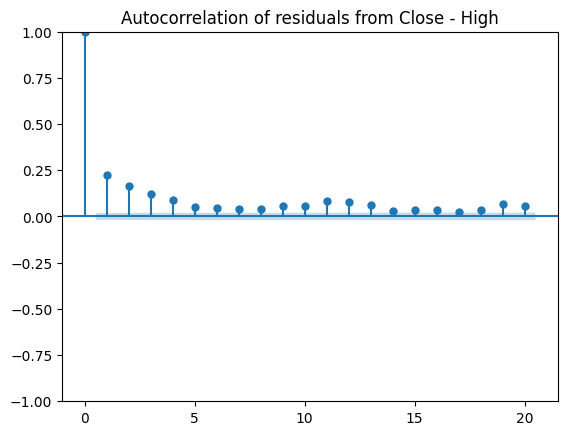

In [22]:
# Check residuals
residuals = results.resid
_ = plot_acf(residuals, lags=20, title="Autocorrelation of residuals from Close - High")

In [23]:
X = add_constant(dataset_us_aug['Low'])
model = OLS(Y, X)
results = model.fit()
print(results.params)

# Test \beta = 1
print(results.t_test("Low = 1"))

const   -11.784863
Low       1.007247
dtype: float64
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0072      0.000     39.460      0.000       1.007       1.008


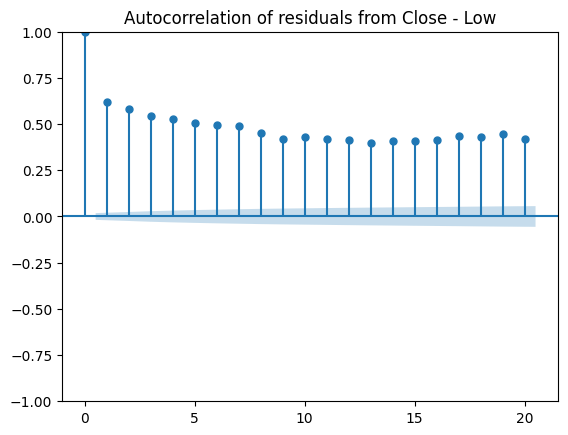

In [24]:
# Check residuals
residuals = results.resid
_ = plot_acf(residuals, lags=20, title="Autocorrelation of residuals from Close - Low")

The t-test on coefficient $\beta$ provides clear evidence ($p$-value $< 0.05$) to reject that $\beta$ is approximately $1$. Moreover, the error terms are autocorrelated meaning these terms in the regression model are not the white noise. These findings suggest that the regression model misses some short-term dynamics; therefore, for short-term predictions, high and low prices should be studied independently.

The next hypothesis is the following:

$H_0$: $X_t$ and $Y_t$ are **not** cointegrated (**do not** share a long-term equilibrium relationship)

In [25]:
from statsmodels.tsa.stattools import coint
_, p_value, _ = coint(dataset_us_aug['High'], dataset_us_aug['Close'])
print(f"Cointegration p-value: {p_value:.4f}")  # p < 0.05 → cointegrated

Cointegration p-value: 0.0000


In [26]:
_, p_value, _ = coint(dataset_us_aug['Low'], dataset_us_aug['Close'])
print(f"Cointegration p-value: {p_value:.4f}")  # p < 0.05 → cointegrated

Cointegration p-value: 0.0000


This null hypothesis is rejected due to the clear statistical evidence ($p$-value $< 0.05$). Therefore, **analyzing close price​ alone is sufficient for long-term trends, as high/low price​ is just close price​ shifted by $\alpha$**.

Lastly, quantify magnitudes of differences.

High-Close:

In [27]:
residual_high_close = dataset_us_aug['High'] - dataset_us_aug['Close']

rel_error = np.mean(np.abs(residual_high_close / dataset_us_aug['Close']))
print(f"Relative Error: {rel_error:.4%}")

Relative Error: 0.1270%


In [28]:
mae = np.mean(np.abs(residual_high_close))
print(f"MAE: {mae:.4f}")

MAE: 3.1942


Low-Close

In [29]:
residual_low_close = dataset_us_aug['Low'] - dataset_us_aug['Close']

rel_error = np.mean(np.abs(residual_low_close / dataset_us_aug['Close']))
print(f"Relative Error: {rel_error:.4%}")

Relative Error: 0.2211%


In [30]:
mae = np.mean(np.abs(residual_low_close))
print(f"MAE: {mae:.4f}")

MAE: 5.7504


#### High and Low Prices

##### Unit Root Test

In [35]:
_, pvalue, *_ = adfuller(dataset_us_aug['High'])
pvalue

0.9883403981790974

In [36]:
_, pvalue, *_ = adfuller(dataset_us_aug['Low'])
pvalue

0.9899275963415005

$p$-values are insufficient to reject the unit root hypothesis. Let's remove the linear trend by the first difference:

In [15]:
returns_high = dataset_us_aug['High'].diff().dropna()

In [37]:
_, pvalue, *_ = adfuller(returns_high)
pvalue

0.0

In [26]:
returns_low = dataset_us_aug['Low'].diff().dropna()

In [38]:
_, pvalue, *_ = adfuller(returns_low)
pvalue

7.621934300223875e-30

The new time series have stationarity proven.

##### Autocorrelation

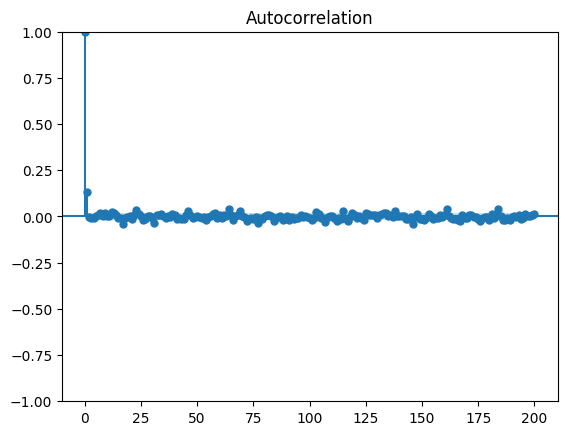

In [16]:
acf_returns_high = plot_acf(returns_high, lags=200)

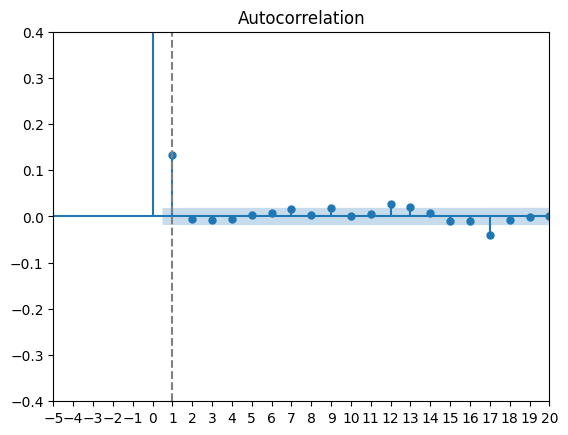

In [25]:
acf_returns_high.axes[0].set_xlim([-5, 20])
acf_returns_high.axes[0].set_xticks(np.arange(-5, 21, 1))
acf_returns_high.axes[0].axvline(x=1, color='grey', linestyle='--')
acf_returns_high.axes[0].set_ylim([-.4, .4])
acf_returns_high

$\text{MA}(1)$ model would fit for forecasting High prices.

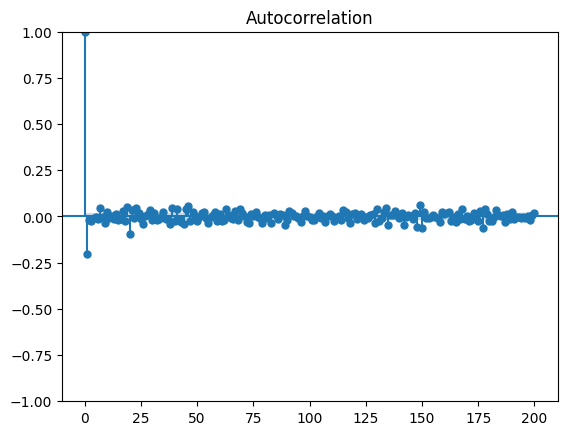

In [27]:
acf_returns_low = plot_acf(returns_low, lags=200)

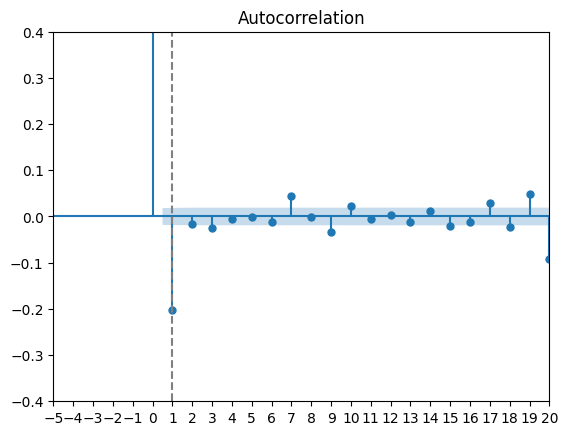

In [29]:
acf_returns_low.axes[0].set_xlim([-5, 20])
acf_returns_low.axes[0].set_xticks(np.arange(-5, 21, 1))
acf_returns_low.axes[0].axvline(x=1, color='grey', linestyle='--')
acf_returns_low.axes[0].set_ylim([-.4, .4])
acf_returns_low

$\text{MA}(1)$ model would fit for forecasting Low prices.

##### Partial Autocorrelation

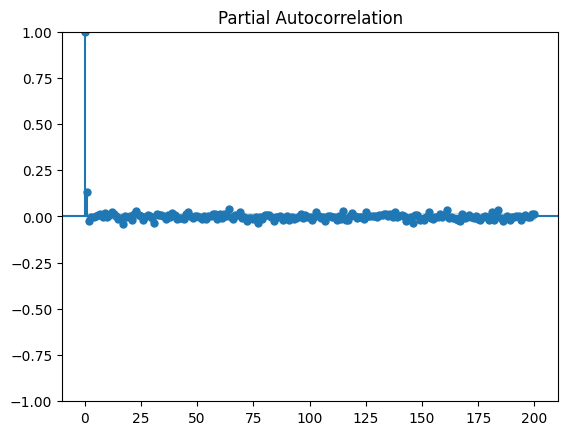

In [31]:
pacf_returns_high = plot_pacf(returns_high, lags=200)

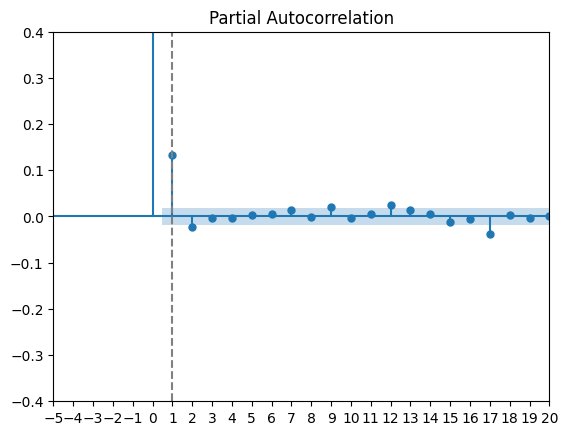

In [32]:
pacf_returns_high.axes[0].set_xlim([-5, 20])
pacf_returns_high.axes[0].set_xticks(np.arange(-5, 21, 1))
pacf_returns_high.axes[0].axvline(x=1, color='grey', linestyle='--')
pacf_returns_high.axes[0].set_ylim([-.4, .4])
pacf_returns_high

$\text{AR}(1)$ model would fit for forecasting High prices.

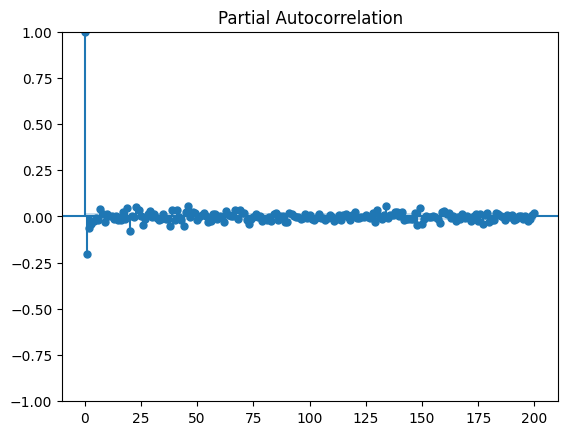

In [33]:
pacf_returns_low = plot_pacf(returns_low, lags=200)

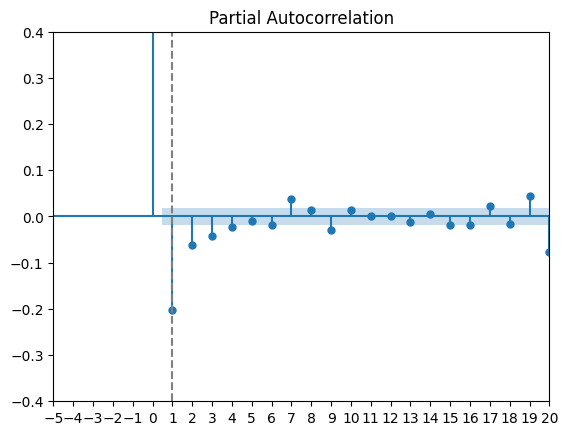

In [34]:
pacf_returns_low.axes[0].set_xlim([-5, 20])
pacf_returns_low.axes[0].set_xticks(np.arange(-5, 21, 1))
pacf_returns_low.axes[0].axvline(x=1, color='grey', linestyle='--')
pacf_returns_low.axes[0].set_ylim([-.4, .4])
pacf_returns_low

$\text{AR}(1)$ model would fit for forecasting Low prices.

#### Volume and Indicators Analysis

##### Volume Time Series

In [149]:
volume_amt = dataset_us_aug['Volume']

###### General View and Outliers

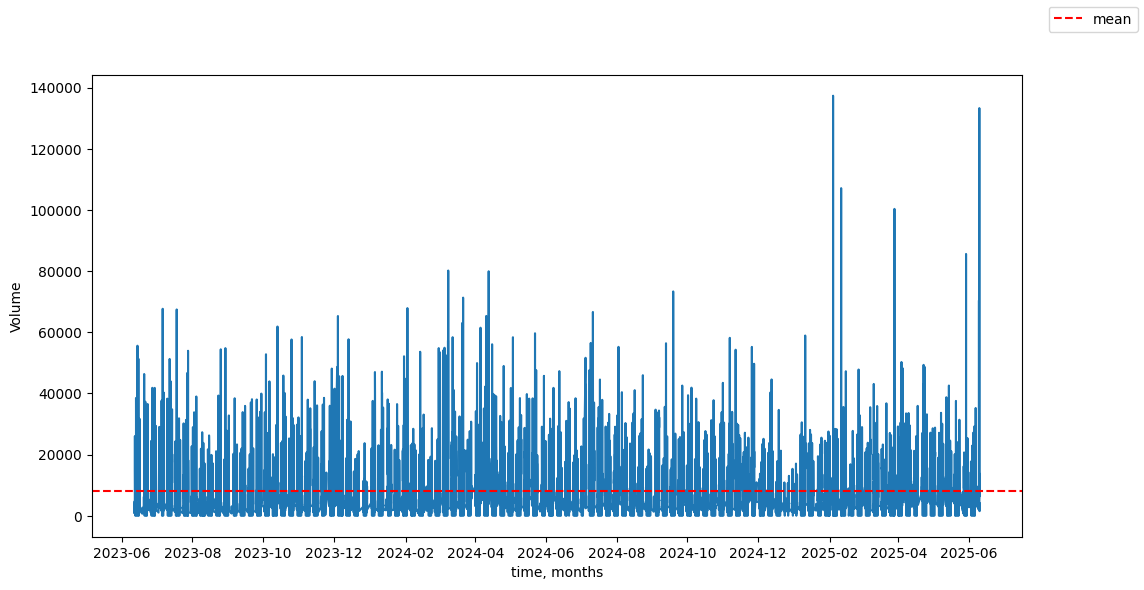

In [40]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
ax.plot(volume_amt.index, volume_amt)
ax.xaxis.set_major_locator(MonthLocator(interval=2))


ax.axhline(volume_amt.mean(), linestyle='--', color='red', label='mean')

ax.set_ylabel('Volume')
ax.set_xlabel(f'time, months')

fig.legend()

The visual analysis suggest that the series is stationary. However, some rigorous testing is necessary to claim this point. One of the powerful statistical tools for this issue is the _augmented Duckey-Fuller test_:

Let $H_0$: the time series has a unit root (equivalently, time series is non-stationary), then find the $p$-value to reject or fail to reject this hypothesis.

In [41]:
_, pvalue, *_ = adfuller(volume_amt)
pvalue

3.4788003321276835e-25

Since $p$-value $< 0.05$, then there is enough evidence to reject the null-hypothesis. Therefore, the time series is indeed stationary.

Let us now focus on outlier detection using quantiles:

In [150]:
Q1, Q3 = volume_amt.quantile([0.25, 0.75])
IQR = Q3 - Q1
outliers = (volume_amt < (Q1 - 1.5 * IQR)) | (volume_amt > (Q3 + 1.5 * IQR))
volume_amt[outliers==True]

Date
2023-06-14 13:00:00+00:00    17213.0
2023-06-22 15:00:00+00:00    16949.0
2023-06-26 14:00:00+00:00    18993.0
2023-06-27 12:00:00+00:00    19046.0
2023-06-27 13:00:00+00:00    17741.0
                              ...   
2025-06-02 13:00:00+00:00    17727.0
2025-06-02 14:00:00+00:00    16444.0
2025-06-03 13:00:00+00:00    18013.0
2025-06-04 12:00:00+00:00    18033.0
2025-06-05 12:00:00+00:00    20234.0
Name: Volume, Length: 541, dtype: float64

Text(0.5, 0, 'time, months')

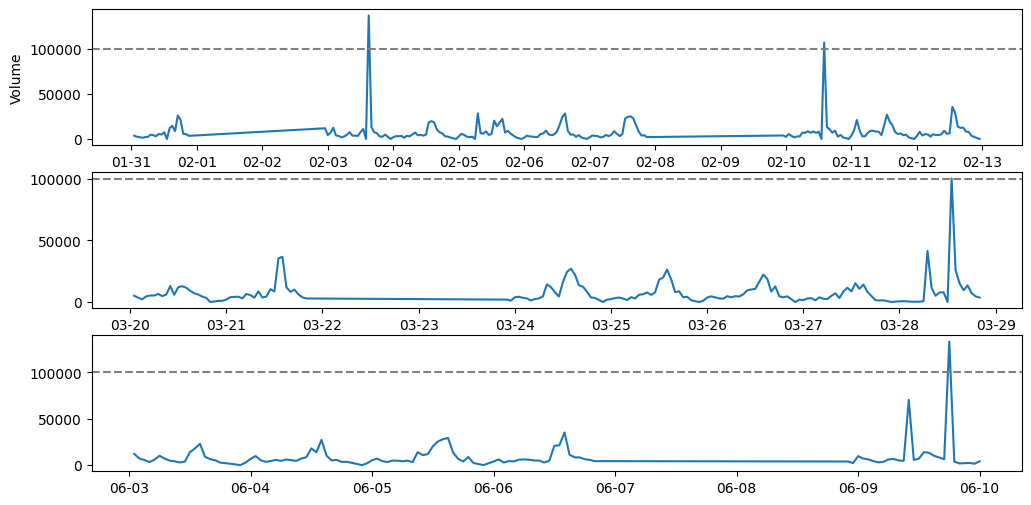

In [34]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 6))

# February 2025
subset_feb_2025 = dataset_us_aug[(dataset_us_aug.index > '2025-01-31') & (dataset_us_aug.index < '2025-02-13')]

ax[0].plot(subset_feb_2025.index, subset_feb_2025['Volume'])
ax[0].xaxis.set_major_locator(DayLocator(interval=1))
ax[0].xaxis.set_major_formatter(DateFormatter('%m-%d'))

# Outliers
ax[0].axhline(1e5, linestyle='--', color='grey')

ax[0].set_ylabel('Volume')
ax[0].set_xlabel(f'time, months')

# March 2025
subset_mar_2025 = dataset_us_aug[(dataset_us_aug.index > '2025-03-20') & (dataset_us_aug.index < '2025-03-30')]
ax[1].plot(subset_mar_2025.index, subset_mar_2025['Volume'])
ax[1].xaxis.set_major_locator(DayLocator(interval=1))
ax[1].xaxis.set_major_formatter(DateFormatter('%m-%d'))

# Outliers
ax[1].axhline(1e5, linestyle='--', color='grey')

# June 2025
subset_june_2025 = dataset_us_aug[(dataset_us_aug.index > '2025-06-03')]
ax[2].plot(subset_june_2025.index, subset_june_2025['Volume'])
ax[2].xaxis.set_major_locator(DayLocator(interval=1))
ax[2].xaxis.set_major_formatter(DateFormatter('%m-%d'))

# Outliers
ax[2].axhline(1e5, linestyle='--', color='grey')

ax[0].set_ylabel('Volume')
ax[0].set_xlabel(f'time, months')

Replace outliers with interpolated values

In [151]:
volume_amt[outliers] = np.nan
volume_amt = volume_amt.interpolate(method='time')

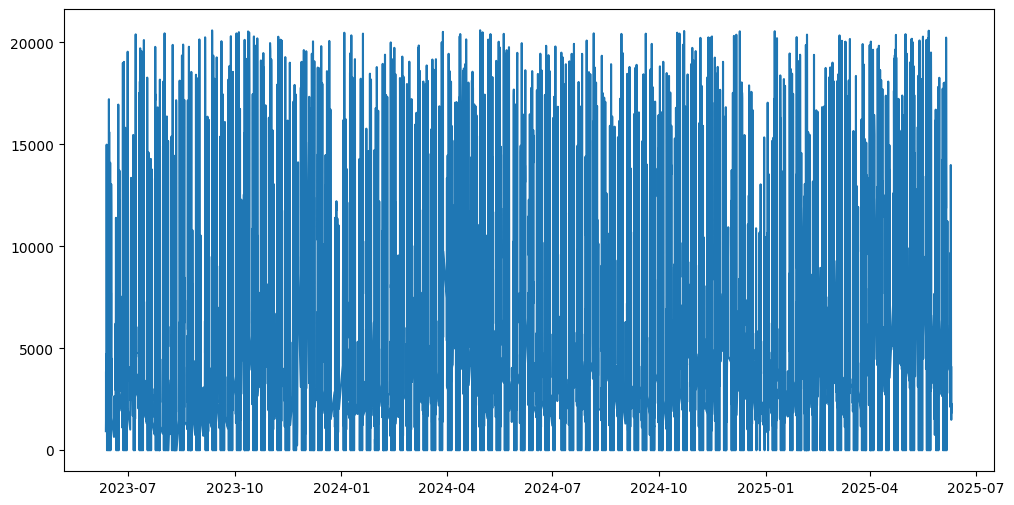

In [9]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))

ax.plot(volume_amt.index, volume_amt)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

###### Year View

In [91]:
volume_amt.index.year

Index([2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023,
       ...
       2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025],
      dtype='int32', name='Date', length=11468)

<Axes: xlabel='Year', ylabel='avg volume'>

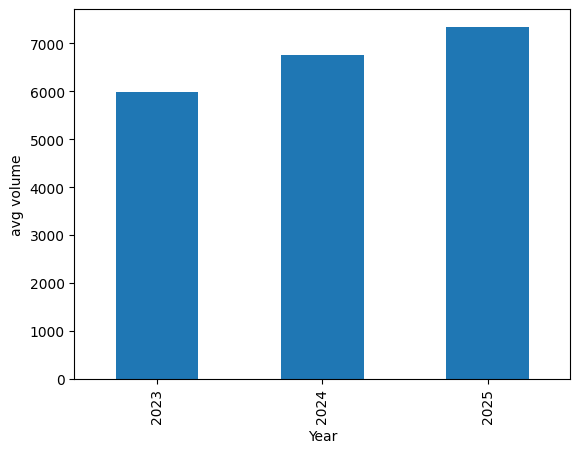

In [93]:
year_order = [2023, 2024, 2025]
volume_amt.groupby(pd.Categorical(volume_amt.index.year, categories=year_order, ordered=True), observed=False).mean().plot(kind='bar', xlabel='Year', ylabel='avg volume')

<Axes: xlabel='Year', ylabel='Trades'>

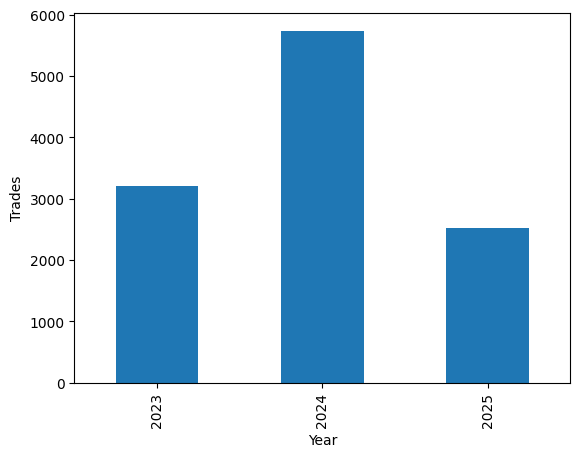

In [94]:
year_order = [2023, 2024, 2025]
volume_amt.groupby(pd.Categorical(volume_amt.index.year, categories=year_order, ordered=True), observed=False).count().plot(kind='bar', xlabel='Year', ylabel='Trades')

The year trend is increasing with the number of trades being disproporitonal: 2023 and 2025 are captured partially.

In [117]:
month_index = volume_amt.index.month.to_series()

season_names = pd.Index(month_index.apply(lambda month: 'Spring' if 3 <= month <= 5 else 'Summer' if month <= 8 else 'Fall' if month <= 11 else 'Winter'))

<Axes: xlabel='Year', ylabel='avg volume'>

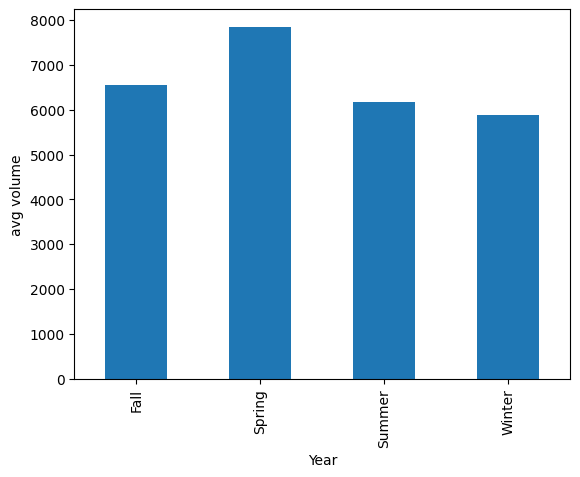

In [119]:
volume_amt.groupby(season_names, observed=False).mean().plot(kind='bar', xlabel='Year', ylabel='avg volume')

###### Month View

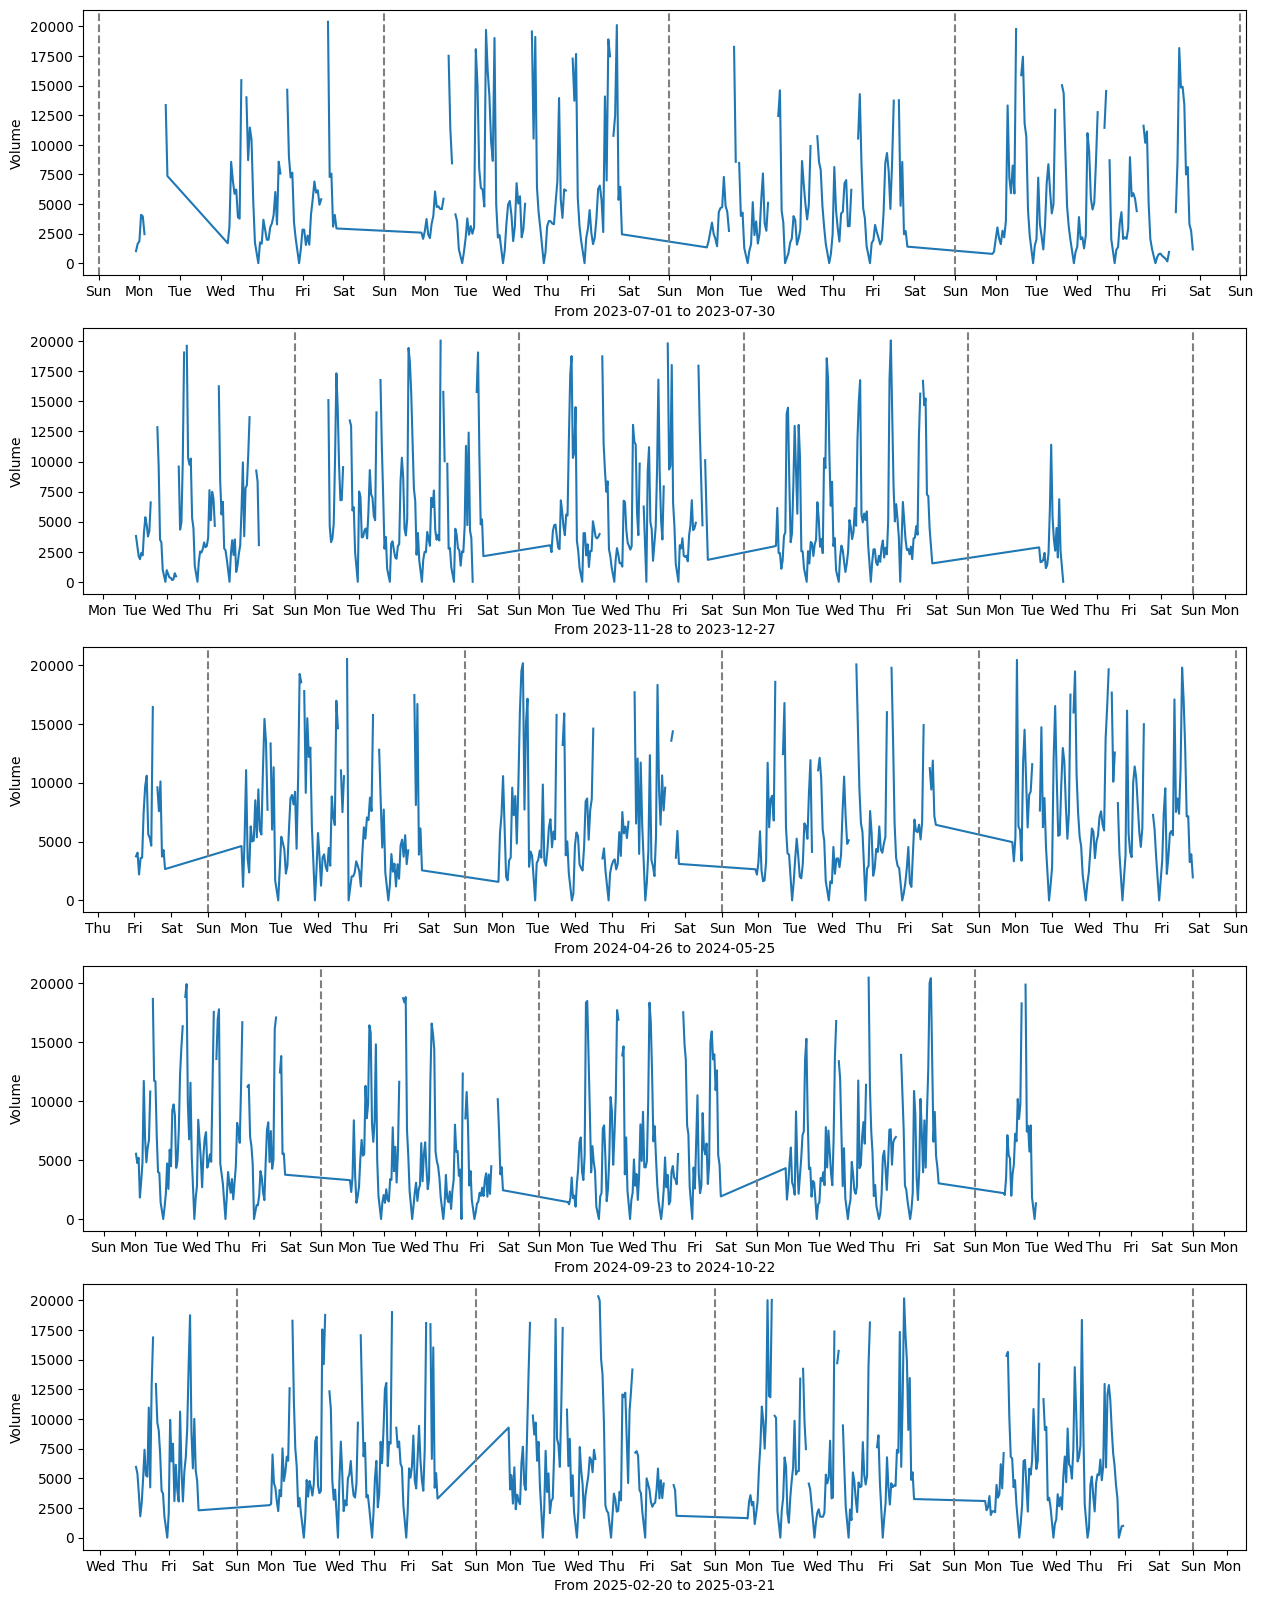

In [67]:
fig, ax = plt.subplots(nrows=5, figsize=(15, 20))

for idx in range(5):
    lb = datetime.date.fromisoformat('2023-07-01') + datetime.timedelta(days=150*idx)
    ub = datetime.date.fromisoformat('2023-07-30') + datetime.timedelta(days=150*idx)
    subset = dataset_us_aug[(lb.__str__() < dataset_us_aug.index) & (dataset_us_aug.index < ub.__str__())]
    
    
    ax[idx].plot(subset.index, subset['Volume'])
    ax[idx].xaxis.set_major_locator(DayLocator(interval=1))
    ax[idx].xaxis.set_major_formatter(DateFormatter('%a'))

    sunday = pd.to_datetime(lb.__str__()).date() + pd.offsets.Week(weekday=6)
    
    for i in range(5):
        ax[idx].axvline(sunday + datetime.timedelta(days=i*7), linestyle='--', color='grey')
    
    ax[idx].set_ylabel('Volume')
    ax[idx].set_xlabel(f"From {lb.__str__()} to {ub.__str__()}")

Based on the visualization of the samples, the volume time series experiences seasonality: the volume amount tends to be higher at the end of the day, and there is a significant drop in volume amount during Saturday and Sunday.

Let's compute the average volume amount per day of the week:

<Axes: xlabel='Day of Week', ylabel='avg volume'>

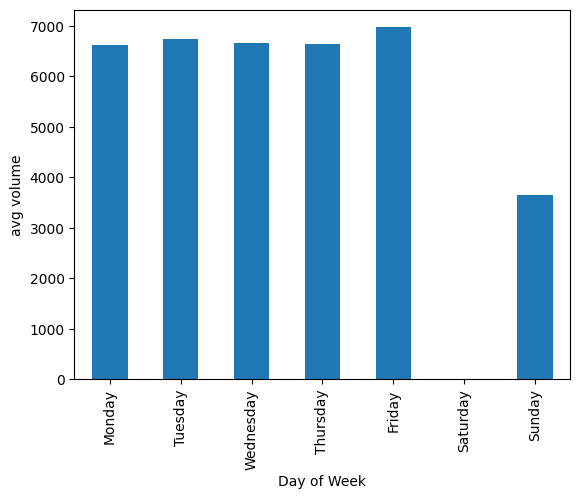

In [84]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
volume_amt.groupby(pd.Categorical(volume_amt.index.day_name(), categories=day_order, ordered=True), observed=False).mean().plot(kind='bar', xlabel='Day of Week', ylabel='avg volume')

The drop in amount during weekend is due to the lack of trades during this period:

<Axes: xlabel='Day of Week', ylabel='Trades'>

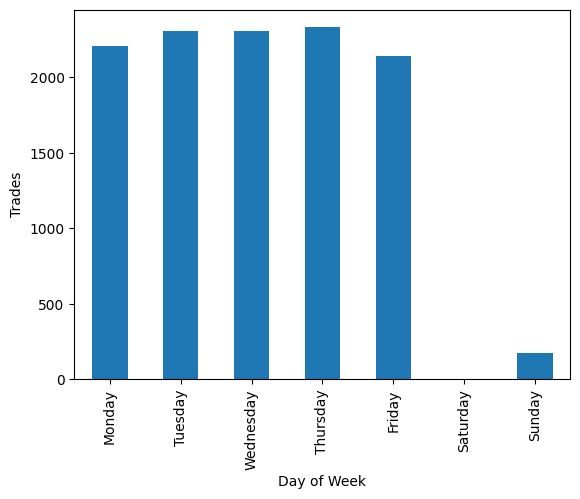

In [85]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
volume_amt.groupby(pd.Categorical(volume_amt.index.day_name(), categories=day_order, ordered=True), observed=False).count().plot(kind='bar', xlabel='Day of Week', ylabel='Trades')

The rest of the weekdays have approximately **the same number of trades**, yet there is **an increase of average amount from Monday to Friday**.

Moreover, let us observe the monthly distribution of trades:

<Axes: xlabel='Month', ylabel='avg volume'>

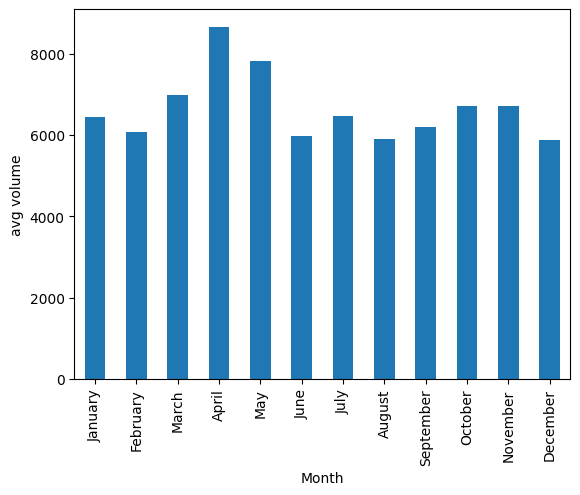

In [86]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
volume_amt.groupby(pd.Categorical(volume_amt.index.month_name(), categories=month_order, ordered=True), observed=False).mean().plot(kind='bar', xlabel='Month', ylabel='avg volume')

<Axes: xlabel='Month', ylabel='Trades'>

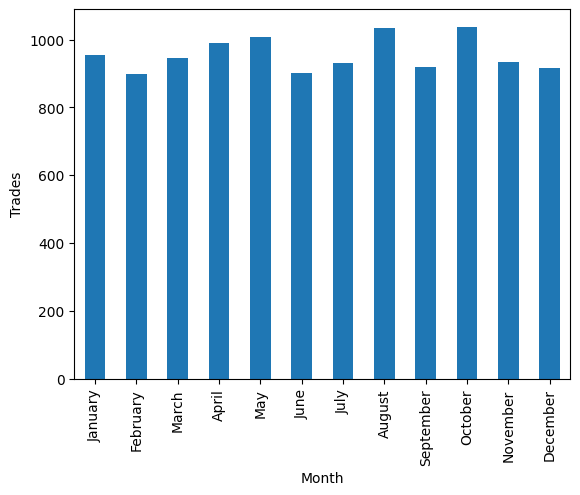

In [87]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
volume_amt.groupby(pd.Categorical(volume_amt.index.month_name(), categories=month_order, ordered=True), observed=False).count().plot(kind='bar', xlabel='Month', ylabel='Trades')

###### Day View

<Axes: xlabel='hour', ylabel='avg volume'>

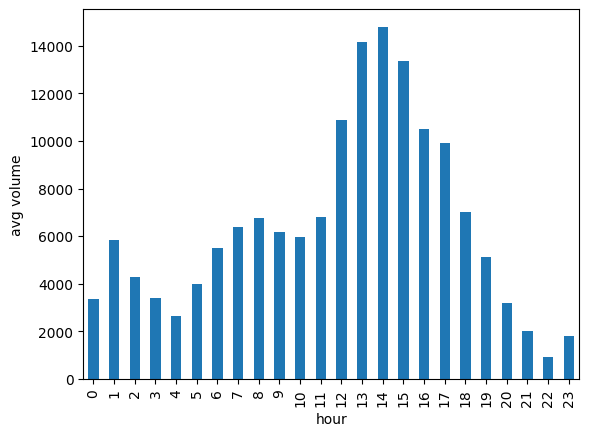

In [88]:
volume_amt.groupby(volume_amt.index.hour).mean().plot(kind='bar', xlabel='hour', ylabel='avg volume')

<Axes: xlabel='hour', ylabel='Trades'>

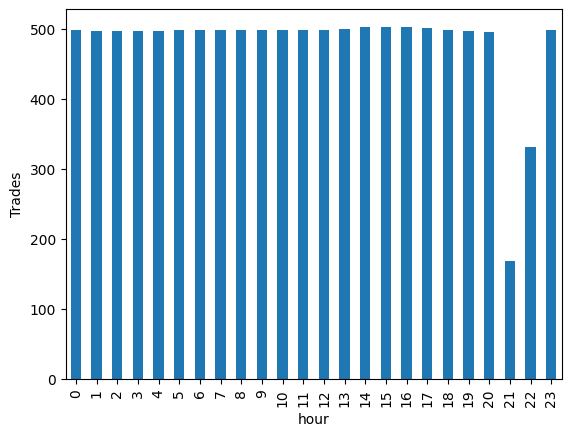

In [89]:
volume_amt.groupby(volume_amt.index.hour).count().plot(kind='bar', xlabel='hour', ylabel='Trades')

Overall, the following information should be used as features of time series analysis: day of week, month, year, season, weekend, hour.

###### Lagged Features

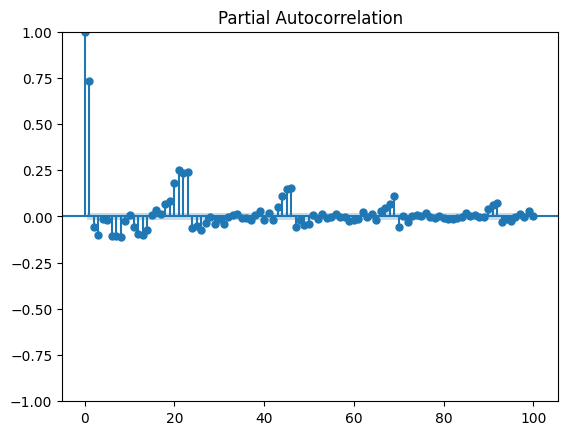

In [131]:
pacf_volume = plot_pacf(volume_amt, lags=100)

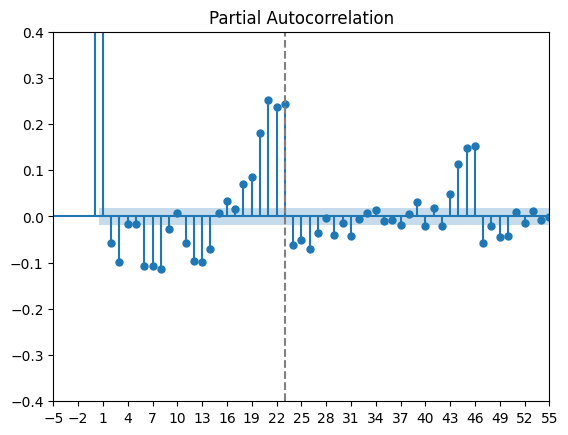

In [137]:
pacf_volume.axes[0].set_xlim([-5, 55])
pacf_volume.axes[0].set_xticks(np.arange(-5, 56, 3))
pacf_volume.axes[0].axvline(x=23, color='grey', linestyle='--')
pacf_volume.axes[0].set_ylim([-.4, .4])
pacf_volume

Although the relevance decrease slowly, we can approximate the model by taking only the most relevant features. Thus, the maximum lag can be set to $25$.

###### Indicators

The following <a href="https://github.com/IU-Capstone-Project-2025/Metalytics/blob/dev/ml/reports/indicators_research.pdf">report</a> highlights the reasons behind using the augmentated dataset. Particularly, indicators for this dataset are presented and justified.

#### Close price distribution

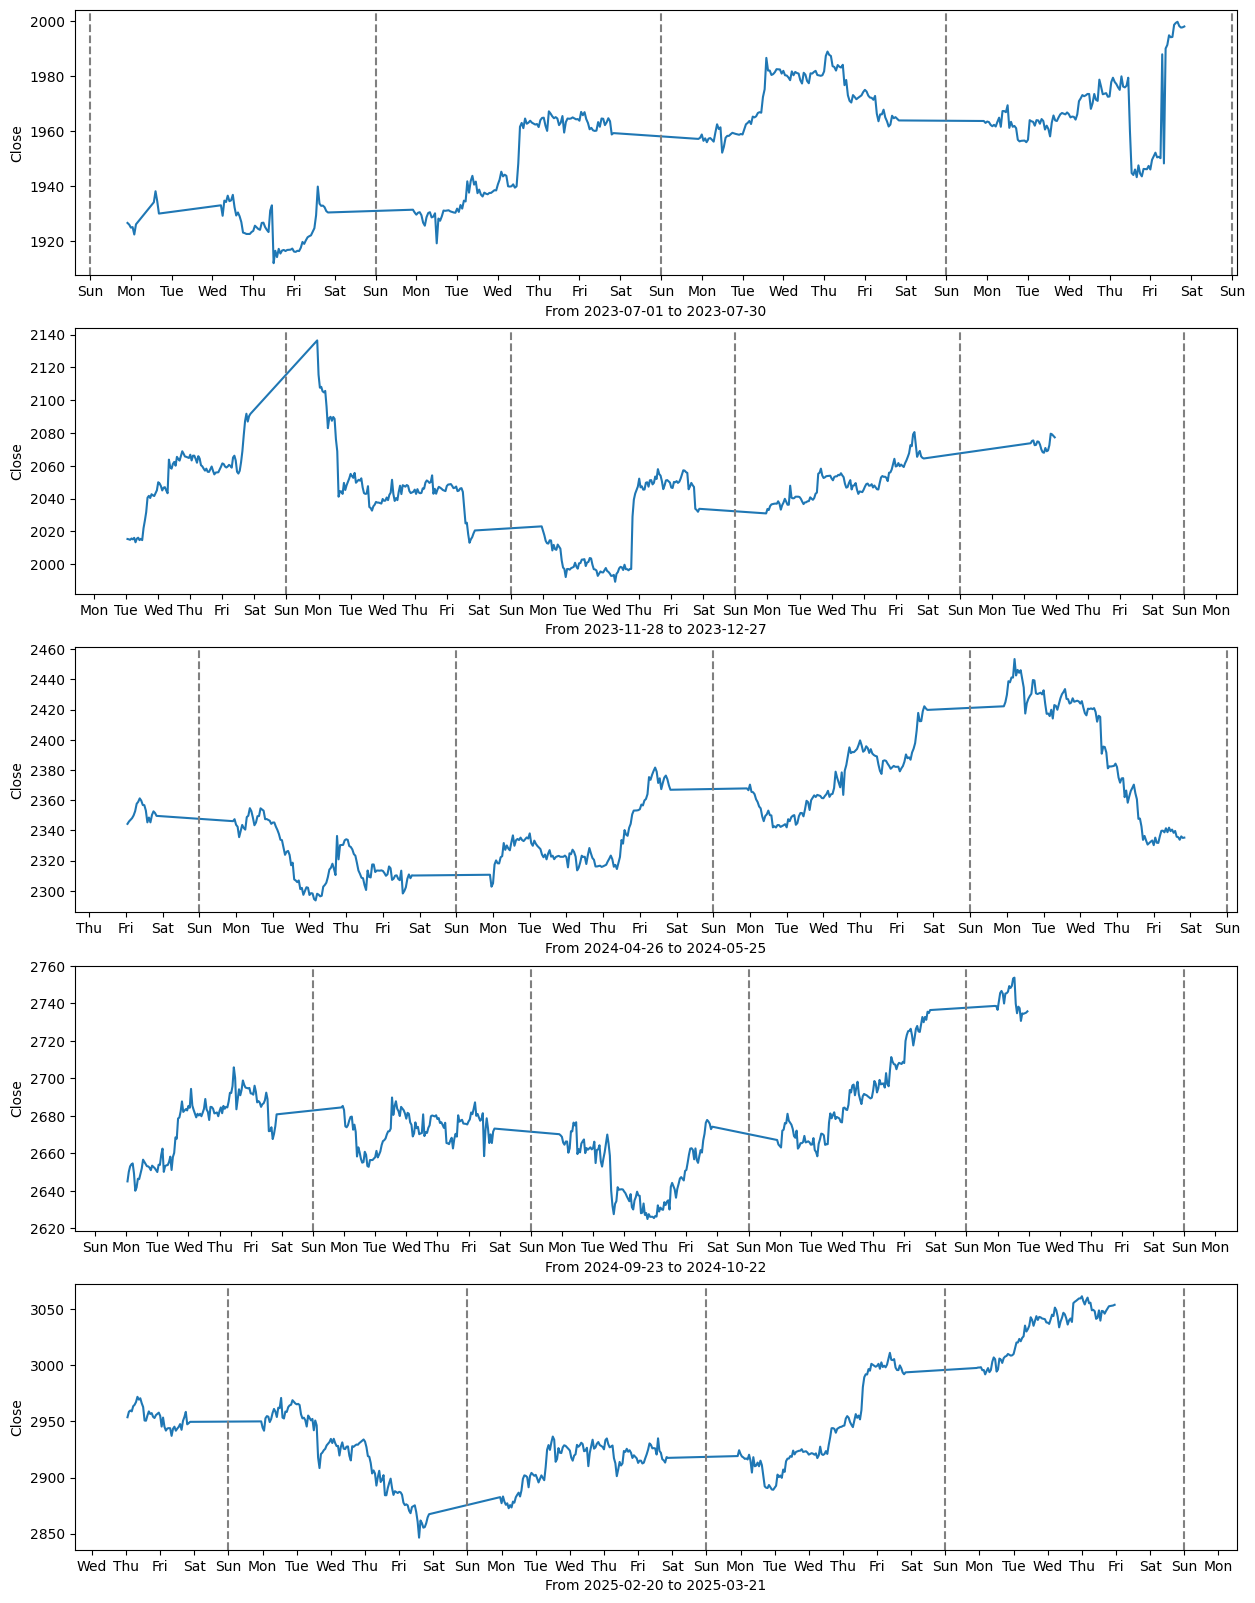

In [40]:
fig, ax = plt.subplots(nrows=5, figsize=(15, 20))

for idx in range(5):
    lb = datetime.date.fromisoformat('2023-07-01') + datetime.timedelta(days=150*idx)
    ub = datetime.date.fromisoformat('2023-07-30') + datetime.timedelta(days=150*idx)
    subset = dataset_us_aug[(lb.__str__() < dataset_us_aug.index) & (dataset_us_aug.index < ub.__str__())]
    
    
    ax[idx].plot(subset.index, subset['Close'])
    ax[idx].xaxis.set_major_locator(DayLocator(interval=1))
    ax[idx].xaxis.set_major_formatter(DateFormatter('%a'))

    sunday = pd.to_datetime(lb.__str__()).date() + pd.offsets.Week(weekday=6)
    
    for i in range(5):
        ax[idx].axvline(sunday + datetime.timedelta(days=i*7), linestyle='--', color='grey')
    
    ax[idx].set_ylabel('Close')
    ax[idx].set_xlabel(f"From {lb.__str__()} to {ub.__str__()}")

Clearly, the behavior of this series does not capture any seasonality.

#### General Conclusions

1. Close price is considered the target for prediction model, while open price is a highly correlated feature with the close price.
2. High and Low price features are slightly distinct from close price in terms of distribution and may affect predictions more compared to open price feature.
3. Volume has seasonality component with period of a week. The trades significantly reduce by the end of the week (with Saturday having no records), and the weekdays have approximately the same trades count. Moreover, the average volume amout increases from Monday to Friday.
4. Close price did not demonstrate seasonality.

### Summary

- Two datasets were presented highlighting the long-term views of several markets and short-term characteristics of Americal futures market gold prices.
- The long-term view on different market suggest strong positive trend across all markets. However, some markets respond to macroeconomic events differently.
- The short-term view on the American futures market revealed correlations between close, open, high, and low prices. Moreover, volume time series was also analysed to demonstrate its seasonal behavior.

# 2. Time Series Properties of Datasets

This chapter is dedicated mainly to time series analysis of the close price from the American futures market gold price dataset. The goal is to apply some classical statistical tests and models to extract useful time series characteristics for future model design.

### Dataset Standartization

In [41]:
dataset_usd_gld = (dataset_gold['USD'] - dataset_gold['USD'].mean()) / dataset_gold['USD'].std()
dataset_aug_cls = (dataset_us_aug['Close'] - dataset_us_aug['Close'].mean()) / dataset_us_aug['Close'].std()

### Unit Root Test
The time series was visually observed to have a trend, which violates the stationary property of a series. Let us use the augmented Duckey-Fuller test to statistically prove that the series is indeed non-stationary.

Let $H_0$: the time series has a unit root (equivalently, time series is non-stationary), then find the $p$-value to reject or fail to reject this hypothesis.

In [42]:
# USD Gold Dataset
_, pvalue_usd_gld, *_ = adataset_aug_cls_reindexeduller(dataset_usd_gld)
pvalue_usd_gld

0.9980277371777525

Since $p$-value $> 0.05$, then there is **not enough** evidence to reject the null-hypothesis. Therefore, the time series is **non-stationary**.

In [43]:
# Futures Gold Dataset
_, pvalue_usd_gld, *_ = adataset_aug_cls_reindexeduller(dataset_aug_cls)
pvalue_usd_gld

0.9859360589638003

Since $p$-value $> 0.05$, then there is **not enough** evidence to reject the null-hypothesis. Therefore, the time series is **non-stationary**.

Non-stationarity implies that some of the following critria are violated:

(1) Mean is constant;

(2) Standard deviation is constant;

(3) No seasonality is present.

Based on the visual analysis, the datasets do not have any (annual) seasonality.

The first difference of components can solve the key problem of two datasets: existing trend. Due to this non-constant mean, the USD gold price and close price time series should be transformed to returns time series (first difference) as follows:

$z_t = y_t - y_{t-1}$, where $y_t$ is the USD gold price / close price time series. Considering the trend is linear, the $z_t$ would be stationary.

Note that the prediction of $z_t$ will happen, and to move back to $y_t$ given $t_f$ is the last recorded value of $y$, we have to do the following transformation:
$$
y_t = z_t + y_{t-1} = z_t + z_{t-1} + y_{t-2} = ... = \sum \limits _{k=0} ^{t_f-1} {z_{t-k}} + y_{t-t_f}
$$

In [44]:
returns_usd_gld = dataset_usd_gld.diff().dropna()
returns_us_aug = dataset_aug_cls.diff().dropna()

The new $p$-values are the following:

In [45]:
# USD Gold Dataset
_, pvalue_usd_gld, *_ = adataset_aug_cls_reindexeduller(returns_usd_gld)
pvalue_usd_gld

0.46900873813210436

In [46]:
# Futures Gold Dataset
_, pvalue_usd_gld, *_ = adataset_aug_cls_reindexeduller(returns_us_aug)
pvalue_usd_gld

0.0

For the USD gold price dataset, the series is still non-stationary but have corrected mean. However, the American futures market gold price time series was corrected to become stationary:

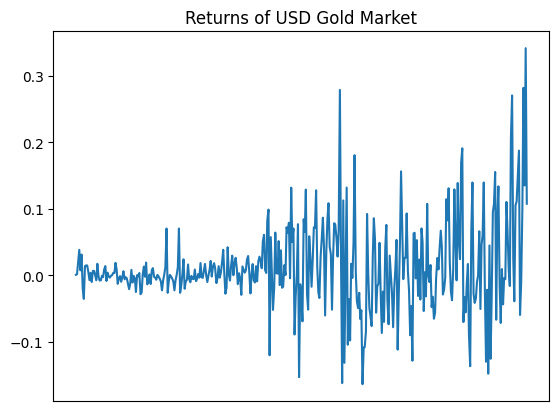

In [47]:
plt.plot(returns_usd_gld.index, returns_usd_gld)
plt.title("Returns of USD Gold Market")
_ = plt.xticks([])

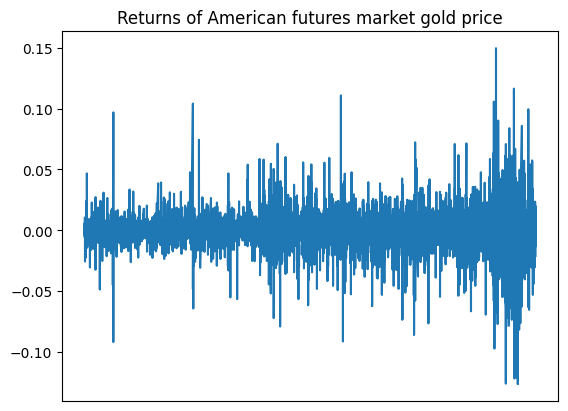

In [48]:
plt.plot(returns_us_aug.index, returns_us_aug)
plt.title("Returns of American futures market gold price")
_ = plt.xticks([])

The USD Gold dataset captures non-constant volatility, which can be fixed by the following transform: divide the time-series within each year by the standard deviation of time-series during this year:

In [49]:
usd_gld_annual_volatility = returns_usd_gld.groupby(returns_usd_gld.index.year).std()
usd_gld_annual_volatility_reindexed = returns_usd_gld.index.map(lambda d : usd_gld_annual_volatility.loc[d.year])

In [50]:
returns_usd_gld /= usd_gld_annual_volatility_reindexed

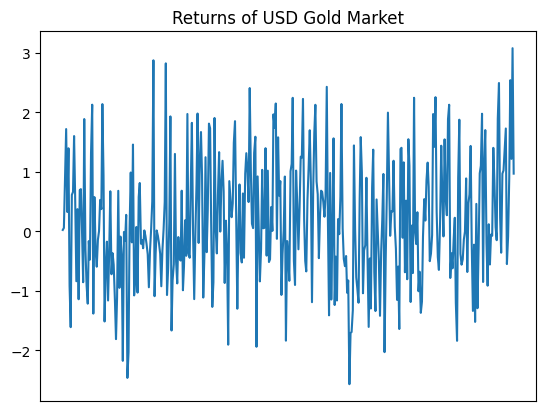

In [51]:
plt.plot(returns_usd_gld.index, returns_usd_gld)
plt.title("Returns of USD Gold Market")
_ = plt.xticks([])

In [52]:
# USD Gold Dataset
_, pvalue_usd_gld, *_ = adataset_aug_cls_reindexeduller(returns_usd_gld)
pvalue_usd_gld

3.6874609533690353e-25

Finally, the $p$-value is sufficient to reject the null-hypothesis for the USD gold dataset as well.

### Autocorrelation Function (ACF)

Autocorrelation function is a transformation of the original data in the form of correlation components at different lags. Each correlation is evaluated between the last observation $y_t$ and the lagged by $k$ observation $y_{t-k}$. Additionally, the correlation also includes all indirect components such as dependency of $y_{t}$ on $y_{t-k}$ through $y_{t-k+m}$, where $0 < m < k$.

Moreover, the significance area is computed to detect correlation components that statistically matter.

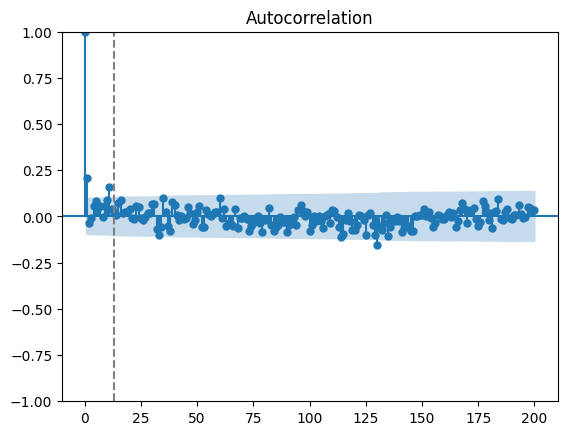

In [53]:
# USD Gold Dataset
gld_acf = plot_acf(returns_usd_gld, lags=200)
gld_acf.axes[0].axvline(x=13, linestyle='--', color='grey')

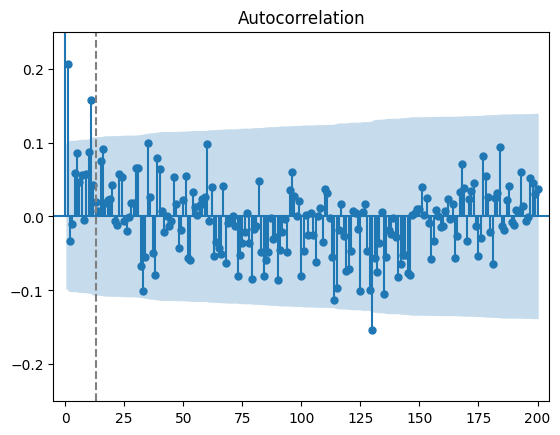

In [54]:
gld_acf.axes[0].set_xlim([-5, 205])
gld_acf.axes[0].set_ylim([-0.25, .25])
gld_acf

Based on the plot, the first $11$ components are worth to be considered as features for this dataset. From the definition of the Moving Average (MA) model, the order of MA model is set from the number of significant components. Therefore, $\text{MA}(13)$ model can be used to model the process.

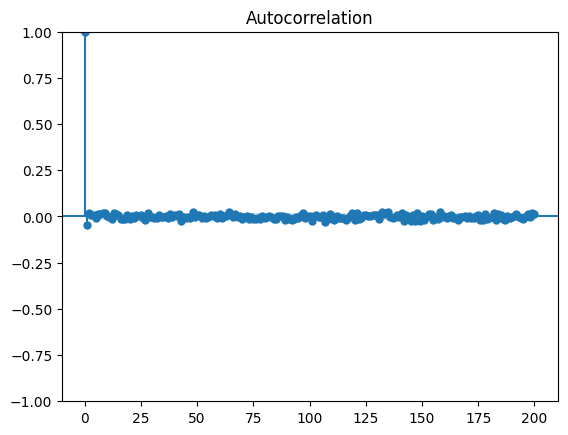

In [55]:
# Futures Gold Dataset
gld_us_aug_acf = plot_acf(returns_us_aug, lags=200)

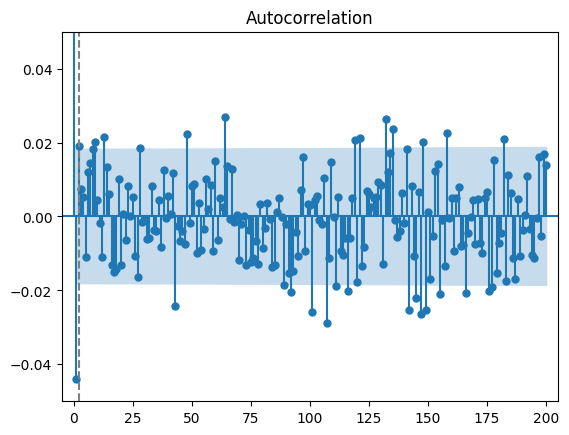

In [56]:
gld_us_aug_acf.axes[0].set_xlim([-5, 205])
gld_us_aug_acf.axes[0].set_ylim([-0.05, .05])
gld_us_aug_acf.axes[0].axvline(x=2, linestyle='--', color='grey')
gld_us_aug_acf

The number of significant lags can evaluated to be around $2$ with lags having some small impact on the target. Thus, $\text{MA}(2)$ may model this process but the autocorrelation seems to be poor.

### Partial Autocorrelation Function (PACF)

PACF suggest the direct contribution of the lagged moment to the prediction of the value of the time series at time $t$. The PACF reduces the indirect contribution of forward components observed in the ACF analysis.

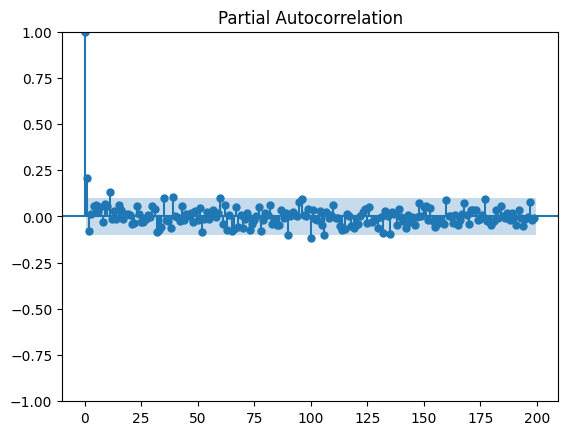

In [57]:
# USD Gold Dataset
ax = plt.axes()
gld_pacf = plot_pacf(returns_usd_gld, lags=len(returns_usd_gld)/2, ax=ax)

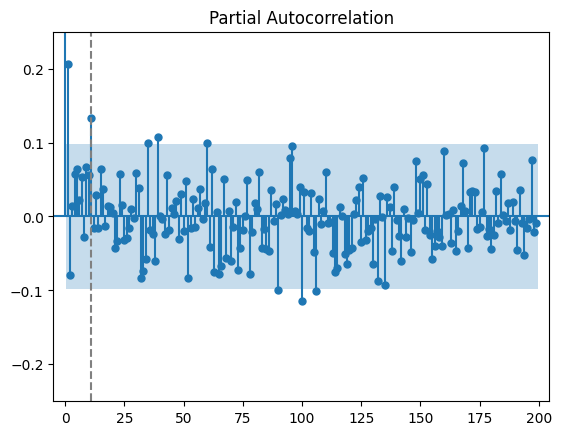

In [58]:
gld_pacf.axes[0].set_xlim([-5, len(returns_usd_gld)/2 + 5])
gld_pacf.axes[0].set_ylim([-0.25, .25])
gld_pacf.axes[0].axvline(x=11, linestyle='--', color='grey')
gld_pacf

Based on the plot, the first $11$ lags limit have some direct correlation with the target. The correlation is observed to slowly converge towards zero. The order of the autoregressive model is defined to be the number of significant lags. Thus, $\text{AR}(11)$ down to $\text{AR}(3)$ can model this process.

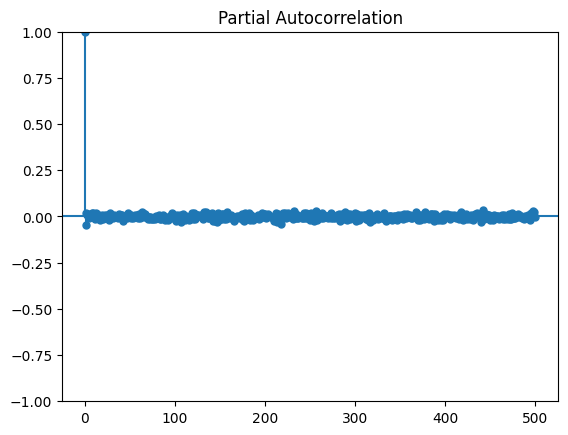

In [59]:
# Futures Gold Dataset
ax = plt.axes()
gld_us_aug_pacf = plot_pacf(returns_us_aug, lags=500, ax=ax)

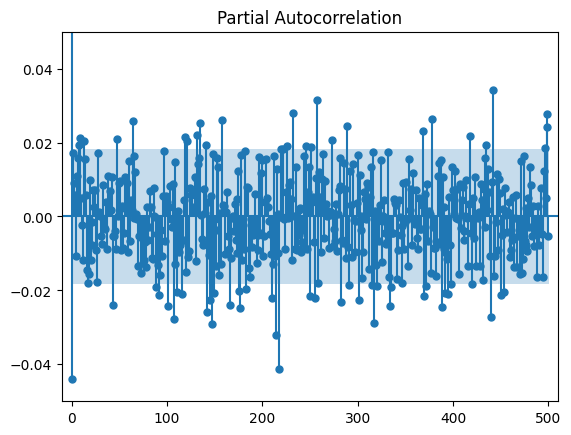

In [60]:
gld_us_aug_pacf.axes[0].set_xlim([-10, 510])
gld_us_aug_pacf.axes[0].set_ylim([-0.05, .05])
gld_us_aug_pacf

In contrast, the hourly measured gold price time series features insignificant correlations without any convergence. Although $\text{AR}(p)$ model may be tested with some small parameter $p$, the series seem to be uncorrelated of its past values.

# 3. Distribution Similarity Analysis

The following <a href="https://github.com/IU-Capstone-Project-2025/Metalytics/blob/dev/ml/reports/market_research.pdataset_aug_cls_reindexed">report</a> justifies the reason for the analysis simplification from Russian market to American one for short-term gold price forecasting.

# 4. Regression Models

Based on the datasets analysis, the regression models are proposed to forecast the time series effectively. This chapter is dedicated for the model descriptions, feature selection, tuning, training, and evaluation.

## I. Classical ML for Time Series

### Baseline Model
To get started with time series, create a baseline model for predicting the prices for a currency. The results would suggest the needs for optimizations if the model overfits or underfits, such as regularization, filtration, and increasing complexity. The simplest yet efficient approach is _autoregression_ (AR).

### Time Series Regression Representation
Due to the sequential manner of such series, the regression task is to extrapolate the functional dependency between time and target. For simplicity of primal analysis, assume the target is fully dependent on the previous observations only. To create features of the new dataset, decompose dataset into a set of vectors, each containing $h$ successive observations. Then, train the model on the dataset, and evaluate on unseen data by composing features in the same manner.

### AR Model for USD Gold Dataset
Initial probe of model training framework

In [61]:
def decompose_data(data: np.array, h: int) -> Tuple[np.array, np.array]:
    """
    Compose features from successive dataset objects using sliding window.

    For example, [y_1, y_2, y_3, y_4, ...] (h=2) would produce

        ([ [y_1, y_2], [y_2, y_3], ...], [y_3, y_4, ...]).

    Parameters:
        data (np.array): 1D-array of target observations.
        h (int): sliding window size.

    Returns:
        Tuple[np.array, np.array]: tuple of sampled dataset of h features
        and the target value for them.
    """
    X = sliding_window_view(data, window_shape=h)[:-1, :]
    X = np.concatenate((X, np.ones(shape=(len(X), 1))), axis=1)
    y = data[h:]
    return (X, y)

In [94]:
train_set, test_set = dataset_gold[dataset_gold.index < '2022-01-01'], dataset_gold[dataset_gold.index >= '2022-01-01']

In [95]:
# Cross-validation with training set getting larger and validation set moving further in time

K = 10
Q_mse = 0
Q_mae = 0
Q_mape = 0
Q_R2 = 0
for k in range(K):
    year = 2010 + k
    train_portion, validation_portion = train_set[train_set.index < f'{year}-01-01'], train_set[train_set.index >= f'{year}-01-01']
    
    X_train, y_train = decompose_data(train_portion['USD'], h=9)
    
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)

    X_test, y_test = decompose_data(validation_portion['USD'], h=9)

    y_pred = linear_regressor.predict(X_test)
    Q_mse += mean_squared_error(y_test, y_pred)
    Q_mae += mean_absolute_error(y_test, y_pred)
    Q_mape += mean_absolute_percentage_error(y_test, y_pred)
    Q_R2 += r2_score(y_test, y_pred)
Q_mse /= K
Q_mae /= K
Q_mape /= K
Q_R2 /= K

In [96]:
print(f"MSE: {Q_mse}, MAE: {Q_mae}, MAPE: {Q_mape}, R2: {Q_R2}")

MSE: 2523.4539849356756, MAE: 39.36828602446719, MAPE: 0.02667036906417834, R2: 0.946775609948053


In [97]:
X_train, y_train = decompose_data(train_set['USD'], h=9)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

X_test, y_test = decompose_data(test_set['USD'], h=9)

y_pred = linear_regressor.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred)}, MAE: {mean_absolute_error(y_test, y_pred)}, MAPE: {mean_absolute_percentage_error(y_test, y_pred)}, R2: {r2_score(y_test, y_pred)}")

MSE: 5679.941740923858, MAE: 58.961277764127956, MAPE: 0.025731089122926334, R2: 0.969342037888283


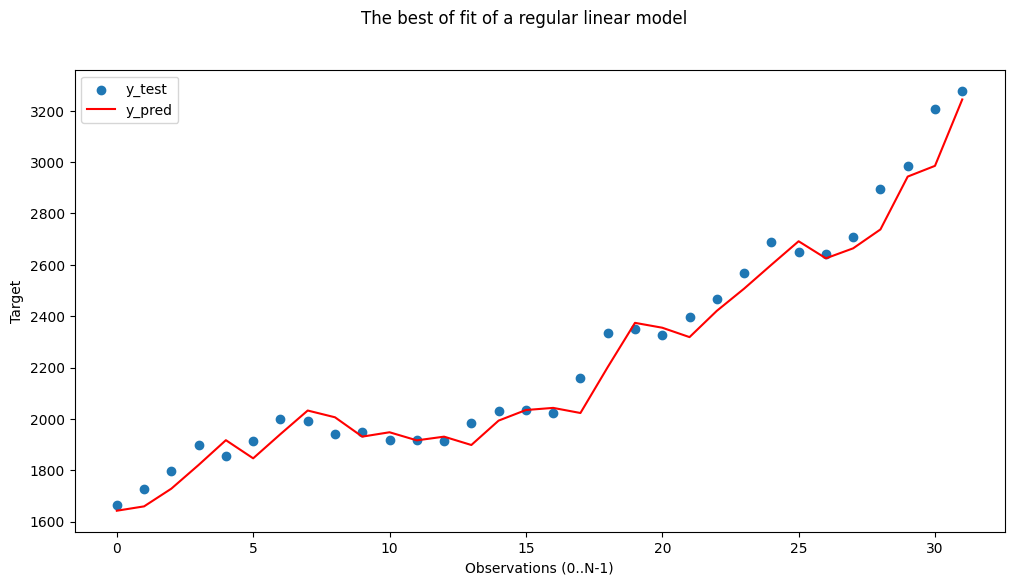

In [66]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
fig.suptitle("The best of fit of a regular linear model")

ax.scatter(np.arange(0, len(y_test)), y_test, label='y_test')
ax.plot(np.arange(0, len(y_test)), y_pred, color='red', label='y_pred')
ax.set_xlabel("Observations (0..N-1)")
ax.set_ylabel('Target')
ax.legend()

### ARMA and ARIMA Models for USD Gold Dataset

In [185]:
returns_usd_gld_reindexed = returns_usd_gld.asfreq('m')
dataset_usd_gld_reindexed = dataset_usd_gld.asfreq('m')

#### ARMA Model for the Original Time Series

In [195]:
train_size = int(len(dataset_usd_gld_reindexed) * 0.6)
train_set, test_set = dataset_usd_gld_reindexed.iloc[:train_size], dataset_usd_gld_reindexed.iloc[train_size:]

In [197]:
model_arima = ARIMA(train_set, order=(2, 1, 2))

In [198]:
result_arima = model_arima.fit()
result_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    USD   No. Observations:                  239
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 268.980
Date:                Thu, 19 Jun 2025   AIC                           -527.961
Time:                        21:22:37   BIC                           -510.599
Sample:                    02-29-1992   HQIC                          -520.964
                         - 12-31-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0169      0.029      0.576      0.564      -0.041       0.074
ar.L2          0.9819      0.029     33.614      0.000       0.925       1.039
ma.L1         -0.0328      0.064     -0.511      0.610      -0.159       0.093
ma.L2         -0.9023      0.061    -14.734      0.000      -1.022      -0.782
sigma2         0.0017      0.000     15.565      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   3.86   Jarque-Bera (JB):              1254.10
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):              33.02   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: title={'center': 'Residuals'}, xlabel='Date'>

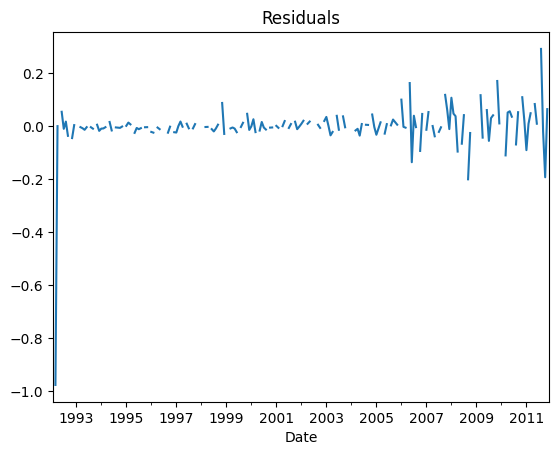

In [199]:
residuals = result_arima.resid
residuals.plot(title="Residuals")

In [200]:
y_pred = result_arima.predict(start=test_set.index[0], end=test_set.index[-1], dynamic=False)

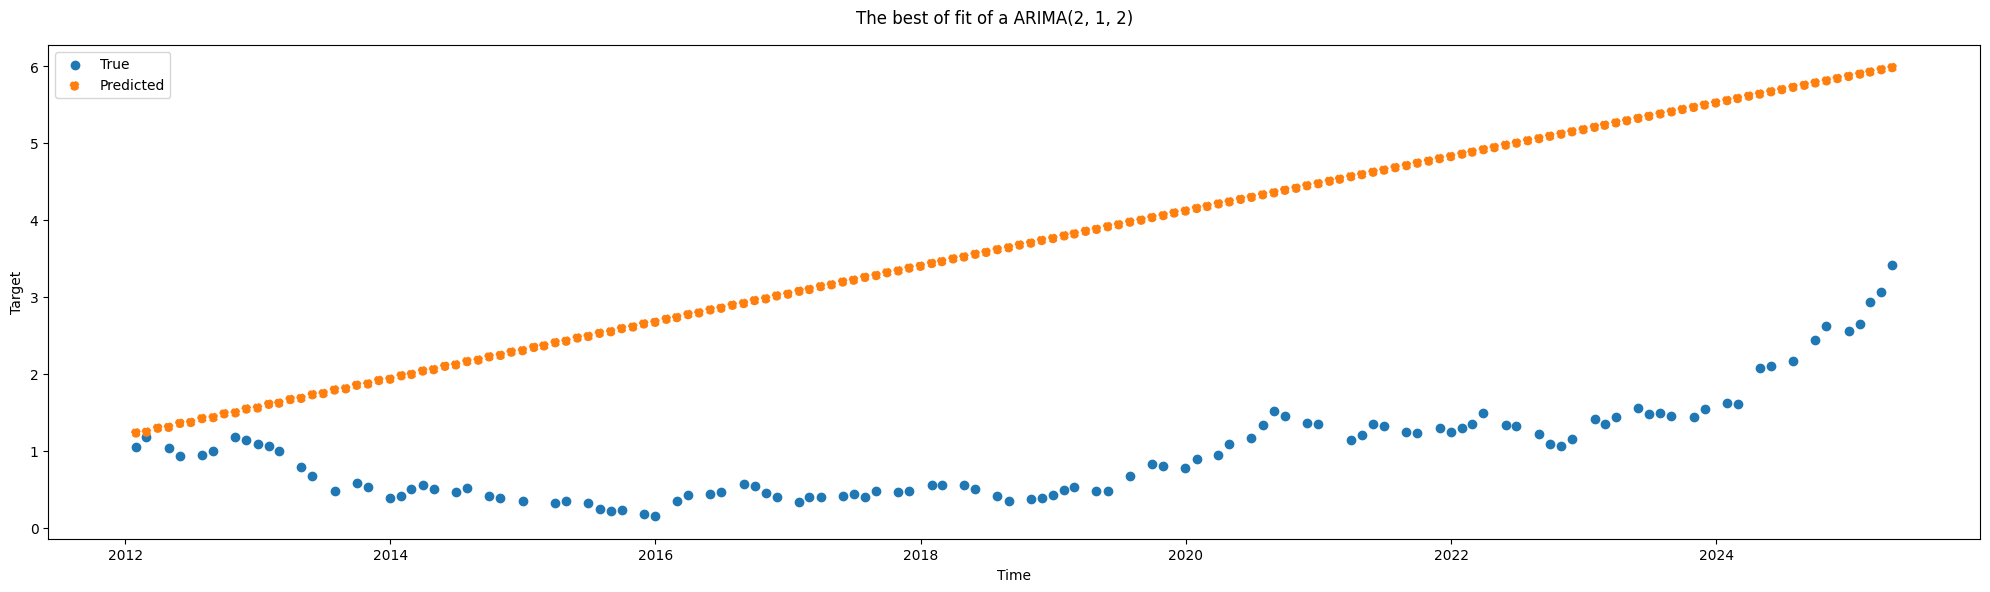

In [201]:
fig, ax = plt.subplots(nrows=1, figsize=(20, 6))
fig.suptitle("The best of fit of a ARIMA(2, 1, 2)")

ax.scatter(test_set.index, test_set, label='True')
ax.scatter(test_set.index, y_pred, label='Predicted', linestyle='--')
ax.set_xlabel("Time")
ax.set_ylabel('Target')
ax.legend()
fig.tight_layout()

#### ARMA Model for the 1st Difference Time Series

In [186]:
train_size = int(len(returns_usd_gld_reindexed) * 0.6)
train_set, test_set = returns_usd_gld_reindexed.iloc[:train_size], returns_usd_gld_reindexed.iloc[train_size:]

In [187]:
model_arma = ARIMA(train_set, order=(2, 0, 2))

In [188]:
result_arma = model_arma.fit()
result_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    USD   No. Observations:                  238
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -237.254
Date:                Thu, 19 Jun 2025   AIC                            486.508
Time:                        21:18:57   BIC                            507.341
Sample:                    03-31-1992   HQIC                           494.904
                         - 12-31-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1812      0.243      0.744      0.457      -0.296       0.658
ar.L1          0.1000      0.407      0.246      0.806      -0.698       0.898
ar.L2          0.8738      0.398      2.196      0.028       0.094       1.654
ma.L1         -0.0396      0.378     -0.105      0.917      -0.780       0.701
ma.L2         -0.8585      0.347     -2.475      0.013      -1.538      -0.179
sigma2         0.9314      0.105      8.862      0.000       0.725       1.137
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                20.33
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.30
Prob(H) (two-sided):                  0.86   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: title={'center': 'Residuals'}, xlabel='Date'>

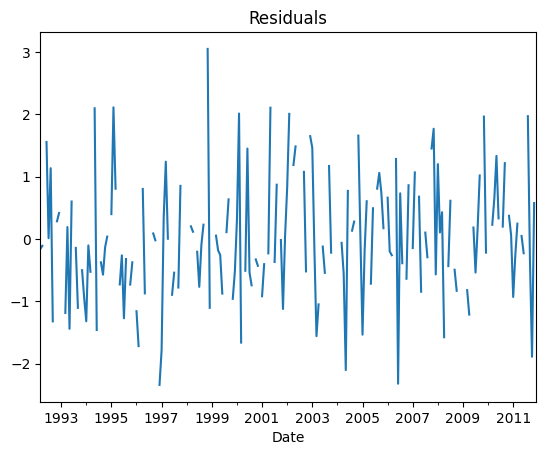

In [189]:
residuals = result_arma.resid
residuals.plot(title="Residuals")

In [190]:
y_pred = result_arma.predict(start=test_set.index[0], end=test_set.index[-1], dynamic=False)

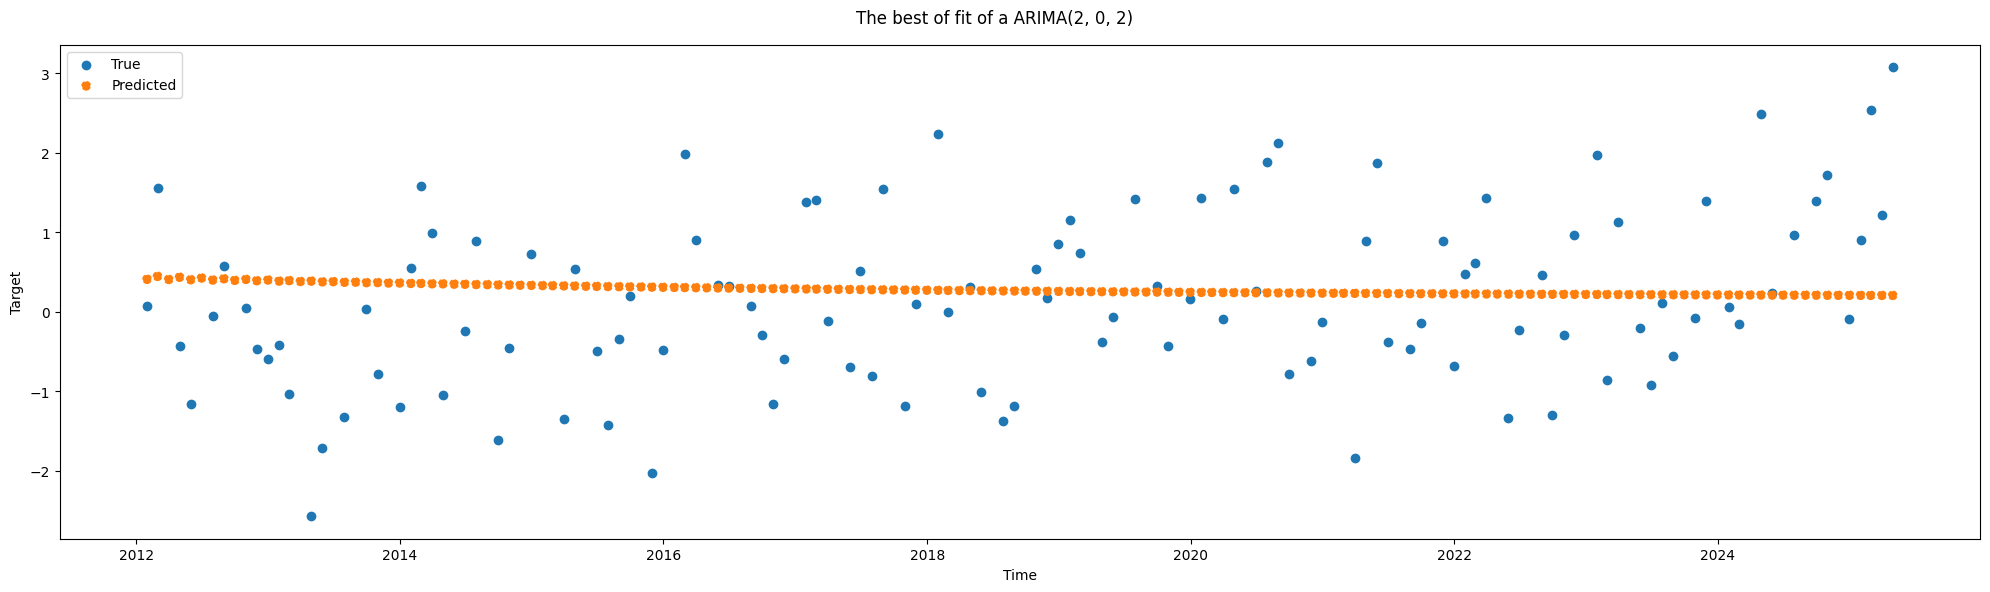

In [194]:
fig, ax = plt.subplots(nrows=1, figsize=(20, 6))
fig.suptitle("The best of fit of a ARIMA(2, 0, 2)")

ax.scatter(test_set.index, test_set, label='True')
ax.scatter(test_set.index, y_pred, label='Predicted', linestyle='--')
ax.set_xlabel("Time")
ax.set_ylabel('Target')
ax.legend()
fig.tight_layout()

### ARIMA Models for American Futures Gold Dataset
The rest of the analysis is dedicated to the American Futures Gold dataset due to availability of additional features.

#### ARMA model for difference time series

In [152]:
returns_us_aug_reindexed = returns_us_aug.asfreq('h')
dataset_aug_cls_reindexed = dataset_aug_cls.asfreq('h')

train_size = int(len(dataset_aug_cls_reindexed) * 0.98)
train_set, test_set = dataset_aug_cls_reindexed.iloc[:train_size], dataset_aug_cls_reindexed.iloc[train_size:]
# train_set, test_set = dataset_aug_cls_reindexed[dataset_aug_cls_reindexed.index < '2024-06-01'], dataset_aug_cls_reindexed[dataset_aug_cls_reindexed.index >= '2024-06-02']

In [153]:
model_arma = ARIMA(train_set, order=(2, 0, 2))

In [154]:
result_arma = model_arma.fit()
result_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                17149
Model:                 ARIMA(2, 0, 2)   Log Likelihood               33366.061
Date:                Thu, 19 Jun 2025   AIC                         -66720.122
Time:                        21:06:22   BIC                         -66673.624
Sample:                    06-11-2023   HQIC                        -66704.795
                         - 05-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0495      5.567     -0.009      0.993     -10.961      10.862
ar.L1          0.0074      0.011      0.683      0.495      -0.014       0.029
ar.L2          0.9926      0.011     91.578      0.000       0.971       1.014
ma.L1          0.9367      0.012     78.165      0.000       0.913       0.960
ma.L2         -0.0539      0.005    -10.357      0.000      -0.064      -0.044
sigma2         0.0001   6.72e-07    212.258      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   4.86   Jarque-Bera (JB):            391612.97
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               4.80   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
residuals = result_arma.resid
residuals.plot(title="Residuals")

In [156]:
y_pred = result_arma.predict(start=test_set.index[0], end=test_set.index[-1], dynamic=False)

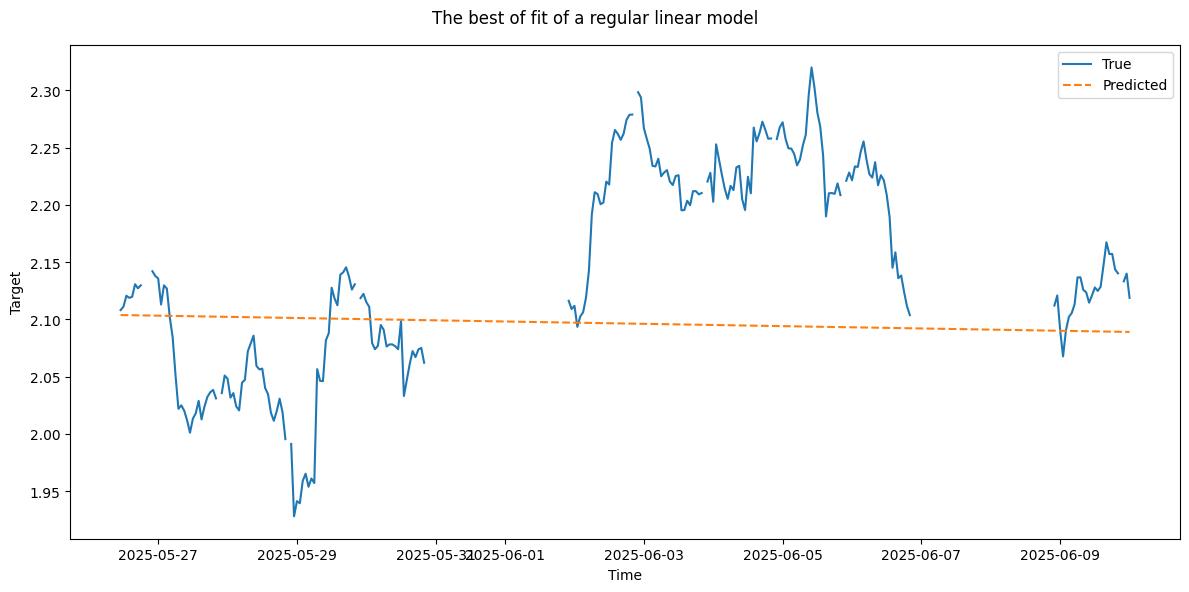

In [160]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
fig.suptitle("The best of fit of ARIMA(2, 0, 2)")

ax.plot(test_set.index, test_set, label='True')
ax.plot(test_set.index, y_pred, label='Predicted', linestyle='--')
ax.set_xlabel("Time")
ax.set_ylabel('Target')
ax.legend()
fig.tight_layout()

### Rolling Forecast Origin ARIMA Model

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
window_size = 24*10  # in hours
forecast_horizon = 250
y_pred = []
y_test = []

# Iterate through test set with rolling window
for start in range(0, len(test_set) - forecast_horizon + 1):
    if (start+1) % 10 == 0:
        print(f"Progress of iteratations: {start+1}/{len(test_set) - forecast_horizon}")
    window_end = train_size + start
    window_start = window_end - window_size

    if window_start < 0:
        continue  # skip if there's not enough history for the window

    train_window = dataset_aug_cls_reindexed.iloc[window_start:window_end]
    
    # Fit ARIMA(2,0,2)
    try:
        model = ARIMA(train_window, order=(2, 0, 2))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=forecast_horizon)
        y_pred.append(forecast.iloc[0])
        y_test.append(dataset_aug_cls_reindexed.iloc[window_end])
    except Exception as e:
        print(f"Model failed at index {window_end}: {e}")
        continue

In [140]:
# Handle NaNs (from reindexing by hour frequency) by imputing with mean

y_test = np.array(y_test)
mean_value = np.nanmean(y_test)
y_test[np.where(np.isnan(y_test))] = mean_value

y_pred = np.array(y_pred)

MSE: 0.000581042577359204,MAE: 0.015220680561845204,MAPE: 0.0074110832765095815, R2: 0.7852972781311208


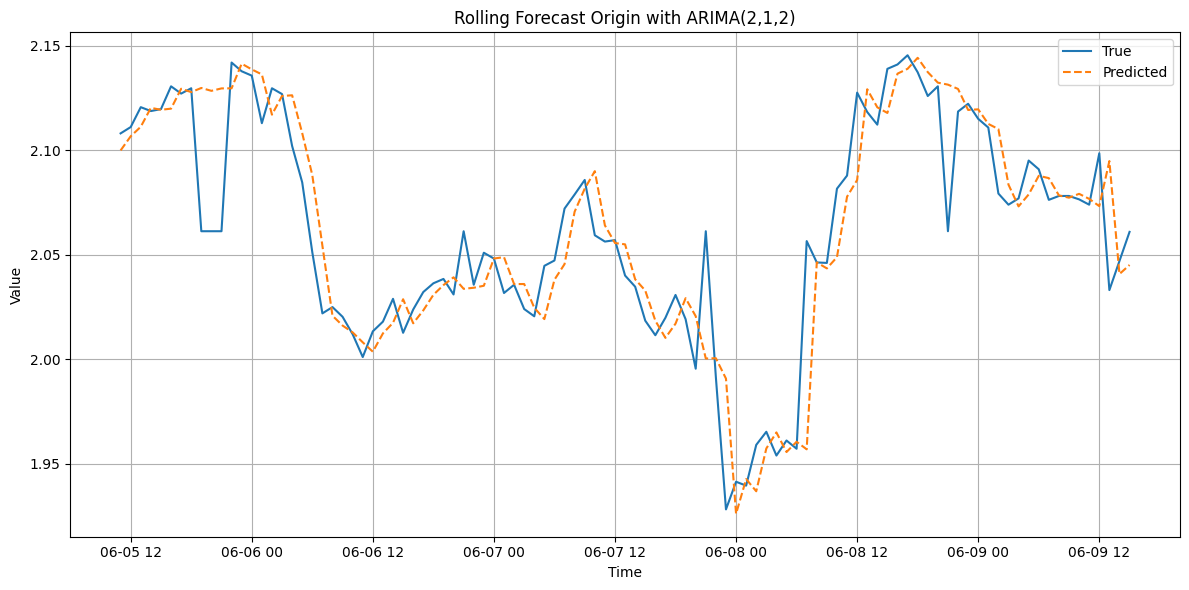

In [143]:
print(
    (f"MSE: {mean_squared_error(y_test, y_pred)},"
    f"MAE: {mean_absolute_error(y_test, y_pred)},"
    f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}, R2: {r2_score(y_test, y_pred)}")
)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(dataset_aug_cls_reindexed.iloc[train_size + window_size:train_size + window_size + len(y_pred)].index, y_pred, label='True')
plt.plot(dataset_aug_cls_reindexed.iloc[train_size + window_size:train_size + window_size + len(y_pred)].index, y_test, label='Predicted', linestyle='--')
plt.title('Rolling Forecast Origin with ARIMA(2,1,2)')
plt.xlabel('Time')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

### AR model with augmented features

In [8]:
def decompose_tabular_data(data: np.array, h: int) -> Tuple[np.array, np.array]:
    """
    Compose features from successive dataset objects using sliding window.

    For example, [y_1, y_2, y_3, y_4, ...] (h=2) would produce

        ([ [*y_1, *y_2, y_3[:, 1:]], [*y_2, *y_3, y_4[:, 1:]], ...], [y_3, y_4, ...]).

    Here *a means unpacking values from a vector.

    Parameters:
        data (np.array): 2D-array of target observations.
        h (int): sliding window size.

    Returns:
        Tuple[np.array, np.array]: tuple of sampled dataset of h features
        and the target value for them.
    """
    X = sliding_window_view(data, window_shape=(h, data.shape[1])).reshape(-1, h * data.shape[1])[:-1, :]
    y = data[h:]
    target, features = y[:, 0], y[:, 1:]
    X = np.hstack([X, features, np.ones(shape=(X.shape[0], 1))])
    return (X, target)

In [99]:
# Cross Validation Split
K = 20
tss = TimeSeriesSplit(n_splits=K, test_size=24*10*1, gap=24)

In [29]:
dataset = dataset_us_aug.copy()

# First difference to remove trend (as proposed in Section 2)
dataset['Close'] = dataset['Close'].diff()
dataset = dataset.dropna()

In [30]:
X, y = decompose_tabular_data(dataset.to_numpy(), 3)
X.shape, y.shape

((10485, 34), (10485,))

In [102]:
Xy = pd.DataFrame(X, y)

In [107]:
preds = []
Q_mse = 0
Q_mae = 0
Q_mape = 0
Q_R2 = 0

for train_idx, val_idx in tss.split(Xy):
    train = Xy.iloc[train_idx]
    val = Xy.iloc[val_idx]

    X_train, y_train = train.to_numpy(), train.index.to_numpy()
    X_val, y_val = val.to_numpy(), val.index.to_numpy()

    regressor = LinearRegression()

    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_val)
    preds.append(y_pred)
    Q_mse += mean_squared_error(y_val, y_pred)
    Q_mae += mean_absolute_error(y_val, y_pred)
    Q_mape += mean_absolute_percentage_error(y_val, y_pred)
    Q_R2 += r2_score(y_val, y_pred)

Q_mse /= K
Q_mae /= K
Q_mape /= K
Q_R2 /= K

In [110]:
print(f"MSE: {Q_mse}, MAE: {Q_mae}, MAPE: {Q_mape}, R2: {Q_R2}")

MSE: 3.6245090259221944e-23, MAE: 4.532296144291182e-12, MAPE: 192.95490885417047, R2: 1.0


In [109]:
dataset_train, dataset_test = dataset[dataset.index < '2025-05-01'], dataset[dataset.index >= '2025-05-01']

X_train, y_train = decompose_tabular_data(dataset_train.to_numpy(), h=3)
X_test, y_test = decompose_tabular_data(dataset_test.to_numpy(), h=3)

regressor = LinearRegression()

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred)}, MAE: {mean_absolute_error(y_test, y_pred)}, MAPE: {mean_absolute_percentage_error(y_test, y_pred)}, R2: {r2_score(y_test, y_pred)}")

MSE: 3.47291635870431e-23, MAE: 4.408442366571558e-12, MAPE: 389.6875975039026, R2: 1.0


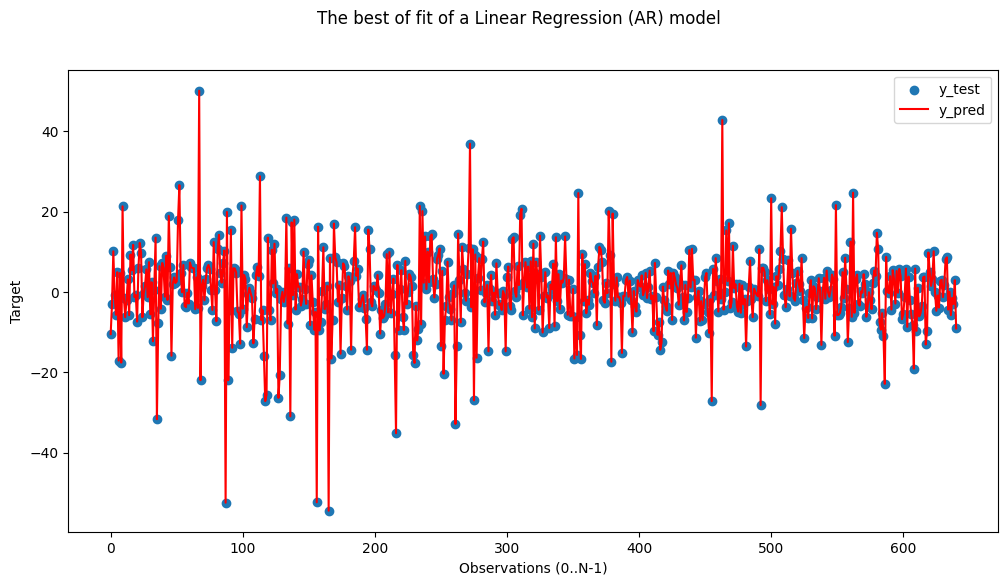

In [112]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
fig.suptitle("The best fit of a Linear Regression (AR) model")

ax.scatter(np.arange(0, len(y_test)), y_test, label='y_test')
ax.plot(np.arange(0, len(y_test)), y_pred, color='red', label='y_pred')
ax.set_xlabel("Observations (0..N-1)")
ax.set_ylabel('Target')
ax.legend()

### XGBoost Model

In [79]:
# Cross Validation Split
K = 20
tss = TimeSeriesSplit(n_splits=K, test_size=24*10*1, gap=24)

In [80]:
dataset = dataset_us_aug.copy()

# First difference to remove trend (as proposed in Section 2)
dataset['Close'] = dataset['Close'].diff()
dataset = dataset.dropna()

In [81]:
X, y = decompose_tabular_data(dataset.to_numpy(), 3)
X.shape, y.shape

((11431, 44), (11431,))

In [82]:
Xy = pd.DataFrame(X, y)

In [103]:
preds = []
Q_mse = 0
Q_mae = 0
Q_mape = 0
Q_R2 = 0

for train_idx, val_idx in tss.split(Xy):
    train = Xy.iloc[train_idx]
    val = Xy.iloc[val_idx]

    X_train, y_train = train.to_numpy(), train.index.to_numpy()
    X_val, y_val = val.to_numpy(), val.index.to_numpy()

    regressor = XGBRegressor(
        base_score=.5,
        booster='gbtree',
        early_stopping_rounds=10,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=.05
    )

    regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=100)

    y_pred = regressor.predict(X_val)
    preds.append(y_pred)
    Q_mse += mean_squared_error(y_val, y_pred)
    Q_mae += mean_absolute_error(y_val, y_pred)
    Q_mape += mean_absolute_percentage_error(y_val, y_pred)
    Q_R2 += r2_score(y_val, y_pred)

Q_mse /= K
Q_mae /= K
Q_mape /= K
Q_R2 /= K

[0]	validation_0-rmse:4.00044	validation_1-rmse:4.08348
[99]	validation_0-rmse:1.97815	validation_1-rmse:1.93475
[0]	validation_0-rmse:4.00388	validation_1-rmse:3.82579
[99]	validation_0-rmse:1.97856	validation_1-rmse:1.83384
[0]	validation_0-rmse:3.99291	validation_1-rmse:4.22264
[99]	validation_0-rmse:1.98688	validation_1-rmse:2.31485
[0]	validation_0-rmse:4.01006	validation_1-rmse:4.85359
[99]	validation_0-rmse:1.98420	validation_1-rmse:2.50703
[0]	validation_0-rmse:4.03156	validation_1-rmse:3.98514
[99]	validation_0-rmse:1.98070	validation_1-rmse:2.03881
[0]	validation_0-rmse:4.03451	validation_1-rmse:4.72749
[99]	validation_0-rmse:1.98625	validation_1-rmse:2.71560
[0]	validation_0-rmse:4.03886	validation_1-rmse:5.82139
[99]	validation_0-rmse:1.98303	validation_1-rmse:3.97287
[0]	validation_0-rmse:4.11823	validation_1-rmse:6.46013
[99]	validation_0-rmse:2.06300	validation_1-rmse:4.01274
[0]	validation_0-rmse:4.19613	validation_1-rmse:5.24839
[99]	validation_0-rmse:2.09706	validatio

In [104]:
print(f"MSE: {Q_mse}, MAE: {Q_mae}, MAPE: {Q_mape}, R2: {Q_R2}")

MSE: 19.87474036227396, MAE: 2.6270514701046825, MAPE: 18215222598697.703, R2: 0.6502512120770085


In [113]:
dataset_train, dataset_test = dataset[dataset.index < '2025-05-01'], dataset[dataset.index >= '2025-05-01']

X_train, y_train = decompose_tabular_data(dataset_train.to_numpy(), h=3)
X_test, y_test = decompose_tabular_data(dataset_test.to_numpy(), h=3)

regressor = XGBRegressor(
    base_score=.5,
    booster='gbtree',
    early_stopping_rounds=10,
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=.05
)

regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

y_pred = regressor.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred)}, MAE: {mean_absolute_error(y_test, y_pred)}, MAPE: {mean_absolute_percentage_error(y_test, y_pred)}, R2: {r2_score(y_test, y_pred)}")

MSE: 41.5174234923925, MAE: 4.208985753904435, MAPE: 30214889727090.17, R2: 0.5739424126993363


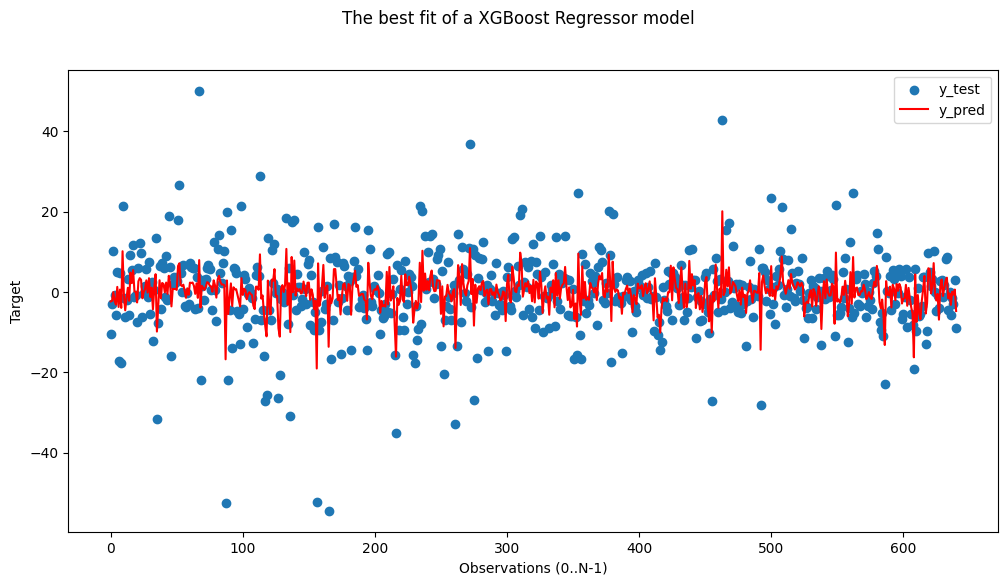

In [114]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
fig.suptitle("The best fit of a XGBoost Regressor model")

ax.scatter(np.arange(0, len(y_test)), y_test, label='y_test')
ax.plot(np.arange(0, len(y_test)), y_pred, color='red', label='y_pred')
ax.set_xlabel("Observations (0..N-1)")
ax.set_ylabel('Target')
ax.legend()

Recovery of original time series (price) from difference:

In [87]:
price_prediction = y_train[-1] + np.cumsum(y_pred)

Dumping baseline model information

In [88]:
# regressor.save_model("model.json")

# 5. Forecasting Framework
The classical forecasting approaches require only the knowledge about lagged target value, whereas the proposed method necessitates availability of additional features (volume, prices, indicators) to extrapolate time-series towards future. Multiple approaches have been proposed, the following <a href="#">report</a> highlights the use case of each.

For the short-term prediction of the baseline model, we implement the autoregressive models **to forecast each of the additional features independently to obtain necessary data for the fit regressor**.

For the short-term prediction of the MVP model, the multivariate regression is applied producing necessary data for future predictions in advance.

This chapter will explore firstly the forecasting of features independently, then assembling new forecasts to produce the general forecasting timeframe, and, finally, develop the interface for forecasting models.

## Forecasting Features

In [202]:
dataset_us_aug.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'EMA20', 'RSI14', 'ATR14',
       'MACD', 'MACD_Signal', 'MACD_Hist'],
      dtype='object')

First, remove what is not necessary. The `Close` price is the target which we know how to predict. The `EMA20`, `RSI14`, `ATR14`, `MACD`, `MACD_Signal`, `MACD_Hist` are indicators calculated based on price features. This indicators will be computed based on the forecasted features later.

Finally, we should prepare models for forecasting `High`, `Low`, `Open`, and `Volume` features.

### `High` and `Low` Prices
The time series of these features are not stationary, but the first difference produces stationary series. Therefore, integrator of the first order should be used. Moreover, the $\text{MA}(1)$ and $\text{AR}(1)$ models are proposed based on the analysis for both features. Therefore, the $\text{ARIMA}(1, 1, 1)$ model is applied for the original series:

In [120]:
high_prices_reindexed = dataset_us_aug['High'].asfreq('h')

In [121]:
high_price_predictor = ARIMA(high_prices_reindexed, order=(1, 1, 1))

In [122]:
results_high_price = high_price_predictor.fit()
results_high_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                17499
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -34029.516
Date:                Sat, 21 Jun 2025   AIC                          68065.033
Time:                        12:47:41   BIC                          68088.342
Sample:                    06-11-2023   HQIC                         68072.709
                         - 06-10-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1130      0.041     -2.727      0.006      -0.194      -0.032
ma.L1          0.2438      0.041      5.977      0.000       0.164       0.324
sigma2        20.8383      0.093    223.487      0.000      20.656      21.021
===================================================================================
Ljung-Box (L1) (Q):                   7.41   Jarque-Bera (JB):            482222.12
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               4.07   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model evaluation**:

In [175]:
train_size = int(len(high_prices_reindexed) * 0.98)
train_set_high_price, test_set_high_price = high_prices_reindexed.iloc[:train_size], high_prices_reindexed.iloc[train_size:]

In [176]:
y_pred = results_high_price.predict(start=test_set_high_price.index[0], end=test_set_high_price.index[-1], dynamic=False)

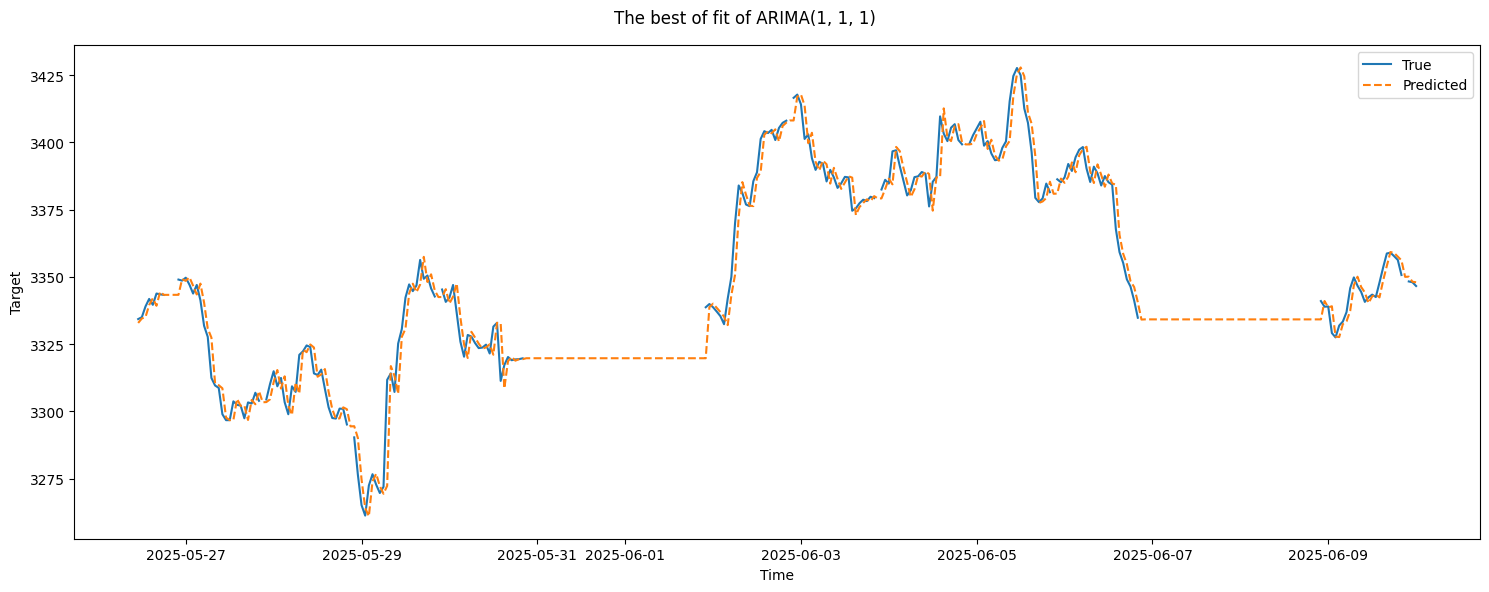

In [178]:
fig, ax = plt.subplots(nrows=1, figsize=(15, 6))
fig.suptitle("The best of fit of ARIMA(1, 1, 1)")

ax.plot(test_set_high_price.index, test_set_high_price, label='True')
ax.plot(test_set_high_price.index, y_pred, label='Predicted', linestyle='--')
ax.set_xlabel("Time")
ax.set_ylabel('Target')
ax.legend()
fig.tight_layout()

In [388]:
low_prices_reindexed = dataset_us_aug['Low'].asfreq('h')

In [389]:
low_price_predictor = ARIMA(low_prices_reindexed, order=(1, 1, 1))

In [390]:
results_low_price = low_price_predictor.fit()
results_low_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Low   No. Observations:                17499
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -39235.034
Date:                Sat, 21 Jun 2025   AIC                          78476.068
Time:                        20:52:54   BIC                          78499.377
Sample:                    06-11-2023   HQIC                         78483.744
                         - 06-10-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2499      0.018     13.981      0.000       0.215       0.285
ma.L1         -0.4769      0.017    -27.814      0.000      -0.510      -0.443
sigma2        52.8463      0.285    185.447      0.000      52.288      53.405
===================================================================================
Ljung-Box (L1) (Q):                   2.18   Jarque-Bera (JB):            268340.19
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               7.82   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model evaluation**:

In [179]:
train_size = int(len(high_prices_reindexed) * 0.98)
train_set_low_price, test_set_low_price = low_prices_reindexed.iloc[:train_size], low_prices_reindexed.iloc[train_size:]

In [180]:
y_pred = results_low_price.predict(start=test_set_low_price.index[0], end=test_set_low_price.index[-1], dynamic=False)

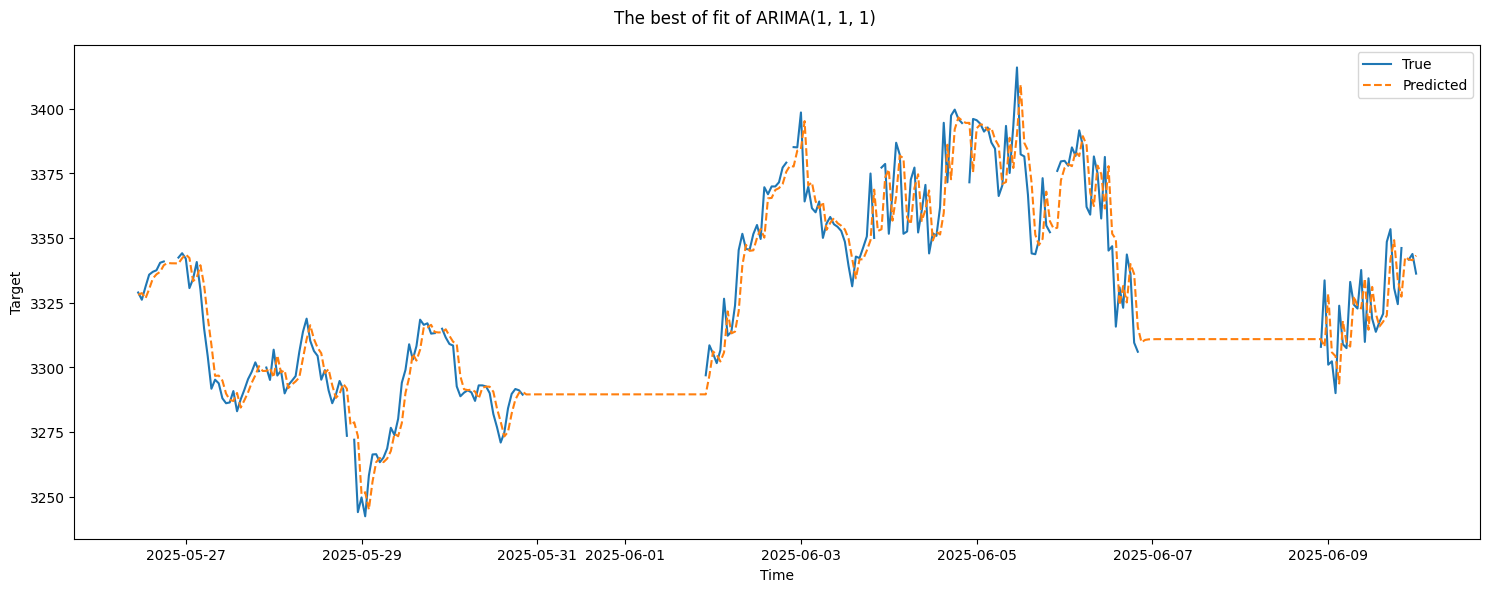

In [181]:
fig, ax = plt.subplots(nrows=1, figsize=(15, 6))
fig.suptitle("The best of fit of ARIMA(1, 1, 1)")

ax.plot(test_set_low_price.index, test_set_low_price, label='True')
ax.plot(test_set_low_price.index, y_pred, label='Predicted', linestyle='--')
ax.set_xlabel("Time")
ax.set_ylabel('Target')
ax.legend()
fig.tight_layout()

### `Volume`

Augment dataset with new features:

In [162]:
df = pd.DataFrame(volume_amt)

# Day of Week (0=Monday, 6=Sunday)
df['day_of_week'] = df.index.dayofweek
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=range(7), ordered=True)

df['year'] = df.index.year
df['year'] = pd.Categorical(df['year'], categories=range(2023, 2026), ordered=True)

# Month (1-12)
month_index = df.index.month

# Cyclical encoding for months (12-month period)
df['month_sin'] = np.sin(2 * np.pi * month_index / 12)
df['month_cos'] = np.cos(2 * np.pi * month_index / 12)

# Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)
df['season'] =  (df.index.month % 12 + 3) // 3
df['season'] = pd.Categorical(df['season'], categories=range(1, 5), ordered=True)

# Weekend flag (1 if Saturday/Sunday, else 0)
df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

# Hour (if your data is intraday)
hour_index = df.index.hour

# Cyclical encoding for hours (24h period)
df['hour_sin'] = np.sin(2 * np.pi * hour_index / 24)
df['hour_cos'] = np.cos(2 * np.pi * hour_index / 24)

In [163]:
# For cyclical features (day_of_week, month, season)
df = pd.get_dummies(df, columns=['day_of_week', 'season'], prefix=['dow', 'season'])

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11468 entries, 2023-06-11 22:00:00+00:00 to 2025-06-10 00:00:00+00:00
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Volume      11468 non-null  float64 
 1   year        11468 non-null  category
 2   month_sin   11468 non-null  float64 
 3   month_cos   11468 non-null  float64 
 4   is_weekend  11468 non-null  int32   
 5   hour_sin    11468 non-null  float64 
 6   hour_cos    11468 non-null  float64 
 7   dow_0       11468 non-null  bool    
 8   dow_1       11468 non-null  bool    
 9   dow_2       11468 non-null  bool    
 10  dow_3       11468 non-null  bool    
 11  dow_4       11468 non-null  bool    
 12  dow_5       11468 non-null  bool    
 13  dow_6       11468 non-null  bool    
 14  season_1    11468 non-null  bool    
 15  season_2    11468 non-null  bool    
 16  season_3    11468 non-null  bool    
 17  season_4    11468 non-null  bool    
dtyp

In [165]:
# df['Volume'] = StandardScaler().fit_transform(df[['Volume']])
for feature in ['year', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos']:
    df[feature] = MinMaxScaler().fit_transform(df[[feature]])

In [166]:
df.head()

,Volume,year,month_sin,month_cos,is_weekend,hour_sin,hour_cos,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,season_1,season_2,season_3,season_4
Date,,,,,,,,,,,,,,,,,,
2023-06-11 22:00:00+00:00,937.0,0.0,0.5,0.0,1,0.25000,0.933013,False,False,False,False,False,False,True,False,False,True,False
2023-06-11 23:00:00+00:00,1182.0,0.0,0.5,0.0,1,0.37059,0.982963,False,False,False,False,False,False,True,False,False,True,False
2023-06-12 00:00:00+00:00,1453.0,0.0,0.5,0.0,0,0.50000,1.000000,True,False,False,False,False,False,False,False,False,True,False
2023-06-12 01:00:00+00:00,3860.0,0.0,0.5,0.0,0,0.62941,0.982963,True,False,False,False,False,False,False,False,False,True,False
2023-06-12 02:00:00+00:00,2835.0,0.0,0.5,0.0,0,0.75000,0.933013,True,False,False,False,False,False,False,False,False,True,False


In [193]:
X, y = decompose_tabular_data(df.to_numpy(), 25) # lags = 25
X.shape, y.shape

((11443, 468), (11443,))

In [194]:
Xy = pd.DataFrame(X, y)

Model training and evaluation:

In [195]:
# Cross Validation Split
K = 20
tss = TimeSeriesSplit(n_splits=K, test_size=24*10*1, gap=24)

In [196]:
preds = []
Q_mse = 0
Q_mae = 0
Q_mape = 0
Q_R2 = 0

for train_idx, val_idx in tss.split(Xy):
    train = Xy.iloc[train_idx]
    val = Xy.iloc[val_idx]

    X_train, y_train = train.to_numpy(), train.index.to_numpy()
    X_val, y_val = val.to_numpy(), val.index.to_numpy()

    regressor = LinearRegression()

    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_val)
    preds.append(y_pred)
    Q_mse += mean_squared_error(y_val, y_pred)
    Q_mae += mean_absolute_error(y_val, y_pred)
    Q_mape += mean_absolute_percentage_error(y_val, y_pred)
    Q_R2 += r2_score(y_val, y_pred)

Q_mse /= K
Q_mae /= K
Q_mape /= K
Q_R2 /= K

In [197]:
print(f"MSE: {Q_mse}, MAE: {Q_mae}, MAPE: {Q_mape}, R2: {Q_R2}")

MSE: 5619728.77637435, MAE: 1757.6425807542055, MAPE: 2.4724776255878768e+17, R2: 0.6217551440598623


In [198]:
dataset_train, dataset_test = df[df.index < '2025-05-01'], df[df.index >= '2025-05-01']

X_train, y_train = decompose_tabular_data(dataset_train.to_numpy(), h=25)
X_test, y_test = decompose_tabular_data(dataset_test.to_numpy(), h=25)

regressor = LinearRegression()

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred)}, MAE: {mean_absolute_error(y_test, y_pred)}, MAPE: {mean_absolute_percentage_error(y_test, y_pred)}, R2: {r2_score(y_test, y_pred)}")

MSE: 6027130.61321441, MAE: 1892.8754401959334, MAPE: 1.9424434714358694e+17, R2: 0.5722051728363591


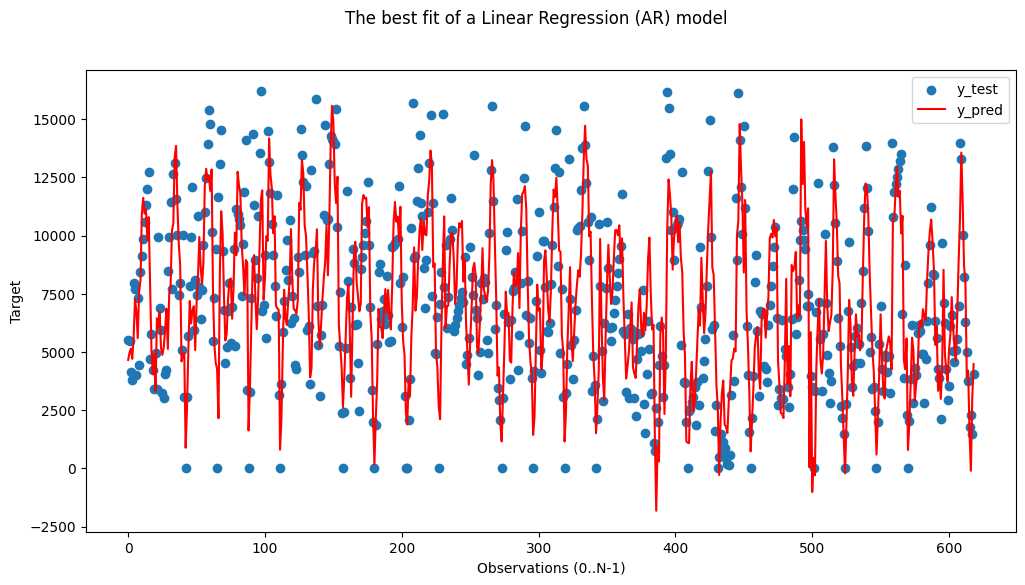

In [199]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
fig.suptitle("The best fit of a Linear Regression (AR) model")

ax.scatter(np.arange(0, len(y_test)), y_test, label='y_test')
ax.plot(np.arange(0, len(y_test)), y_pred, color='red', label='y_pred')
ax.set_xlabel("Observations (0..N-1)")
ax.set_ylabel('Target')
ax.legend()

### `Open` Price
The `Open` price is the lagged time series of the `Close` price. Therefore, the last predicted close price becomes the current open price.

## Time Series Model Class
Different models use distinct feature sets and lags to forecast target. However, the overall forecast should be based only on the existing dataset. To separate the logic of model predictions, a special class is introduced.

In [536]:
class ForecastModel(ABC):
    """
    Class for building dataset, fitting the model, dumping, and loading it.
    """

    @abstractmethod
    def fit(self, df: pd.DataFrame):
        """
        Creates dataset from `df` and fits the model to the dataset.

        Parameters:
            df (pd.DataFrame): dataframe from which dataset is built.

        Returns:
            self (ForecastModel)
        """
        pass

    @abstractmethod
    def predict(self, date_range: pd.DatetimeIndex) -> pd.Series:
        """
        Creates forecast series of a given date range.

        Parameters:
            date_range (pd.DatetimeIndex): range of dates for index.

        Returns:
            pd.Series: forecasted series.
        """
        pass

    @abstractmethod
    def dump(self, path: str) -> None:
        """
        Saves model to a file.

        Parameters:
            path (str): path to the folder containing file.
        """
        pass

    @abstractmethod
    def load(self, df: pd.DataFrame, path: str) -> None:
        """
        Sets the dataframe and loads the model from a file.

        Parameters:
            df (pd.DataFrame): dataframe from which dataset is built.
            path (str): path to the folder containing file.
        """
        pass

In [537]:
class SLFM(ForecastModel):
    """
    Statistical Lag Forecast Model (ARIMA(1,1,1))

    Attributes:
        feature_name (str): name of the target feature.
        model_ (ARIMA): statistical model.
        model_fit (ARIMAResults): fit model.
    """

    feature_name: str
    model_: ARIMA
    model_fit: ARIMAResults

    def __init__(self, feature_name: str):
        self.feature_name = feature_name
        self.model_ = None
        self.model_fit = None

    def build(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Builds dataset from the dataframe.

        Parameters:
            df (pd.DataFrame): dataframe from which dataset is built.

        Returns:
            pd.DataFrame: prepared dataset.
        """
        prices_reindexed = df[self.feature_name].asfreq('h')
        return prices_reindexed

    def fit(self, df: pd.DataFrame):
        df_ = self.build(df.copy())
        self.model_ = ARIMA(df_, order=(1, 1, 1))
        self.model_fit = self.model_.fit()
        return self

    def predict(self, date_range: pd.DatetimeIndex) -> pd.Series:
        assert self.model_fit is not None
        y_pred = self.model_fit.predict(start=date_range[0], end=date_range[-1], dynamic=False)
        return y_pred

    def dump(self, path: str) -> None:
        self.model_fit.save(f"{path}/{self.feature_name}_predictor.joblib")

    def load(self, df: pd.DataFrame, path: str) -> None:
        self.model_fit = ARIMAResults.load(f"{path}/{self.feature_name}_predictor.joblib")

In [538]:
def compose_forecast_frame(data: np.array, features: np.array, lag: int) -> Tuple[np.array, np.array]:
    """
    Compose features from the last observations and features of forecast timeframe.

    For example, [..., y_{n-k}, ..., y_{n-3}, y_{n-2}, y_{n-1}, y_n] (lag=2) would produce

        [*y_{n-1}, *y_{n}, *features, 1].

    Here *a means unpacking values from a vector.

    Parameters:
        data (np.array): 2D-array of target observations.
        features (np.array): 1D-array of current forecast timeframe features.
        lag (int): number of lagged observations to include.

    Returns:
        1D-array of features for the model prediction.
    """
    X = data[-lag:].reshape(-1, lag * data.shape[1])
    X = np.hstack([X, features.reshape(1, -1), np.ones(shape=(X.shape[0], 1))])
    return X

In [539]:
class VolumeFM(ForecastModel):
    """
    Forecasting model for `Volume` target.

    Model selected: XGBRegressor

    Attributes:
        model_ (BaseEstimator): regression model.
        df_ (pd.DataFrame): dataset built for training
        lag (int): number of lagged features.
    """

    model_: BaseEstimator
    df_: pd.DataFrame
    lag: int

    def __init__(self, lag: int = 25):
        self.lag = lag

    def preprocess_(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocessing of dataframe before building.

        Parameter:
            df (pd.DataFrame): dataframe.

        Returns:
            pd.DataFrame: preprocessed dataframe.
        """
        Q1, Q3 = df.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

        df[outliers] = np.nan
        df = df.interpolate(method='time')

        return df

    def build(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Builds dataset from the dataframe.

        Parameters:
            df (pd.DataFrame): dataframe from which dataset is built.

        Returns:
            pd.DataFrame: prepared dataset.
        """

        df = pd.DataFrame(self.preprocess_(df['Volume']))
        # Day of Week (0=Monday, 6=Sunday)
        df['day_of_week'] = df.index.dayofweek
        df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=range(7), ordered=True)
        
        df['year'] = df.index.year
        df['year'] = pd.Categorical(df['year'], categories=range(2023, 2026), ordered=True)
        
        # Month (1-12)
        month_index = df.index.month
        
        # Cyclical encoding for months (12-month period)
        df['month_sin'] = np.sin(2 * np.pi * month_index / 12)
        df['month_cos'] = np.cos(2 * np.pi * month_index / 12)
        
        # Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)
        df['season'] =  (df.index.month % 12 + 3) // 3
        df['season'] = pd.Categorical(df['season'], categories=range(1, 5), ordered=True)
        
        # Weekend flag (1 if Saturday/Sunday, else 0)
        df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)
        
        # Hour (if your data is intraday)
        hour_index = df.index.hour
        
        # Cyclical encoding for hours (24h period)
        df['hour_sin'] = np.sin(2 * np.pi * hour_index / 24)
        df['hour_cos'] = np.cos(2 * np.pi * hour_index / 24)

        # For cyclical features (day_of_week, month, season)
        df = pd.get_dummies(df, columns=['day_of_week', 'season'], prefix=['dow', 'season'])

        # Scaling is removed to retain original scales in the output
        # df['Volume'] = StandardScaler().fit_transform(df[['Volume']])
        for feature in ['year', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos']:
            df[feature] = MinMaxScaler().fit_transform(df[[feature]])

        return df

    def build_forecast_data(self, df: pd.DataFrame):
        """
        Builds forecasting dataset (indexed with forecasting date range) from the dataframe.

        Parameters:
            df (pd.DataFrame): dataframe from which dataset is built.

        Returns:
            pd.DataFrame: prepared dataset.
        """

        df = pd.DataFrame(df['Volume'])
        # Day of Week (0=Monday, 6=Sunday)
        df['day_of_week'] = df.index.dayofweek
        df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=range(7), ordered=True)
        
        df['year'] = df.index.year
        df['year'] = pd.Categorical(df['year'], categories=range(2023, 2026), ordered=True)
        
        # Month (1-12)
        month_index = df.index.month
        
        # Cyclical encoding for months (12-month period)
        df['month_sin'] = np.sin(2 * np.pi * month_index / 12)
        df['month_cos'] = np.cos(2 * np.pi * month_index / 12)
        
        # Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)
        df['season'] =  (df.index.month % 12 + 3) // 3
        df['season'] = pd.Categorical(df['season'], categories=range(1, 5), ordered=True)
        
        # Weekend flag (1 if Saturday/Sunday, else 0)
        df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)
        
        # Hour (if your data is intraday)
        hour_index = df.index.hour
        
        # Cyclical encoding for hours (24h period)
        df['hour_sin'] = np.sin(2 * np.pi * hour_index / 24)
        df['hour_cos'] = np.cos(2 * np.pi * hour_index / 24)

        # For cyclical features (day_of_week, month, season)
        df = pd.get_dummies(df, columns=['day_of_week', 'season'], prefix=['dow', 'season'])

        # Scaling is removed to retain original scales in the output
        # df['Volume'] = StandardScaler().fit_transform(df[['Volume']])
        for feature in ['year', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos']:
            df[feature] = MinMaxScaler().fit_transform(df[[feature]])

        return df

    def fit(self, df: pd.DataFrame):
        self.df_ = self.build(df.copy())

        X_train, y_train = decompose_tabular_data(self.df_.to_numpy(), h=self.lag)

        train_size = int(len(self.df_) * 0.8)
        train_set, test_set = self.df_.iloc[:train_size], self.df_.iloc[train_size:]

        X_train, y_train = decompose_tabular_data(train_set.to_numpy(), h=self.lag)
        X_test, y_test = decompose_tabular_data(test_set.to_numpy(), h=self.lag)
        
        self.model_ = XGBRegressor(
            base_score=.5,
            booster='gbtree',
            early_stopping_rounds=10,
            objective='reg:squarederror',
            max_depth=3,
            learning_rate=.05
        )

        self.model_.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
        
        return self

    def predict(self, date_range: pd.DatetimeIndex) -> pd.Series:

        prediction_df = self.build_forecast_data(pd.DataFrame(index=date_range, columns=['Volume']))

        for date in date_range:

            feature_columns = [column for column in prediction_df.columns if column != 'Volume']
            features = prediction_df[feature_columns].loc[date].copy()
            
            x_ = compose_forecast_frame(self.df_.to_numpy(), features.to_numpy(), self.lag)
            y_ = self.model_.predict(x_)

            features['Volume'] = y_
            self.df_ = pd.concat([self.df_, features.to_frame().T])

        return self.df_['Volume'].loc[date_range[0]:date_range[-1]]

    def dump(self, path: str) -> None:
        joblib.dump(self.model_, f"{path}/Volume_predictor.joblib")

    def load(self, df: pd.DataFrame, path: str):
        self.df_ = self.build(df.copy())
        self.model_ = joblib.load(f"{path}/Volume_predictor.joblib")

In [540]:
class ClosePriceFM(ForecastModel):
    """
    Forecasting model for `Close` target.

    Selected model: XGBRegressor.

    Attributes:
        model_ (BaseEstimator): regression model.
        feature_models (Dict[str, ForecastModel]): dictionary of auxiliary models and their names.
        df_ (pd.DataFrame): dataset built for training.
        last_close_price (float): price of the last observed close prices.
        lag (int): number of lagged features.
        indicators (List[str]): names of indicators.
    """

    model_: BaseEstimator
    feature_models: Dict[str, ForecastModel]
    df_: pd.DataFrame
    last_close_price: float
    lag: int
    indicators: List[str] = ['EMA20', 'RSI14', 'ATR14', 'MACD', 'MACD_Signal', 'MACD_Hist']

    def __init__(self, lag: int = 25):
        self.lag = lag
        self.feature_models = {
            'High': SLFM('High'),
            'Low': SLFM('Low'),
            'Volume': VolumeFM()
        }

    def build(self, df: pd.DataFrame):
        """
        Builds dataset from the dataframe.

        Parameters:
            df (pd.DataFrame): dataframe from which dataset is built.

        Returns:
            pd.DataFrame: prepared dataset.
        """

        # First difference to remove trend
        self.last_close_price = df.iloc[-1]['Close']
        df['Close'] = df['Close'].diff()
        df = df.dropna()

        return df

    def build_forecast_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Builds forecasting dataset (indexed with forecasting date range) from the dataframe.

        Parameters:
            df (pd.DataFrame): dataframe from which dataset is built.

        Returns:
            pd.DataFrame: prepared dataset.
        """

        # Predict feature targets
        for feature, feature_model in self.feature_models.items():
            df[feature] = self.feature_models[feature].predict(df.index)
        # Set `Open` price
        df['Open'] = np.nan
        df['Open'].iloc[0] = self.df_['Close'].iloc[-1]

        # Set `Close` price
        df['Close'] = np.nan

        # Set Indicators
        for indicator in self.indicators:
            df[indicator] = np.nan
            df[indicator].iloc[0] = self.df_[indicator].iloc[-1]

        return df

    def fit(self, df: pd.DataFrame):
        self.df_ = self.build(df.copy())

        # Fit feature models
        for feature_model in self.feature_models.values():
            feature_model.fit(self.df_)

        X_train, y_train = decompose_tabular_data(self.df_.to_numpy(), h=self.lag)

        train_size = int(len(self.df_) * 0.8)
        train_set, test_set = self.df_.iloc[:train_size], self.df_.iloc[train_size:]

        X_train, y_train = decompose_tabular_data(train_set.to_numpy(), h=self.lag)
        X_test, y_test = decompose_tabular_data(test_set.to_numpy(), h=self.lag)
        
        self.model_ = XGBRegressor(
            base_score=.5,
            booster='gbtree',
            early_stopping_rounds=10,
            objective='reg:squarederror',
            max_depth=3,
            learning_rate=.05
        )

        self.model_.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
        
        return self

    def predict(self, date_range: pd.DatetimeIndex) -> pd.Series:

        prediction_df = self.build_forecast_data(pd.DataFrame(index=date_range))

        for idx, date in enumerate(date_range):

            feature_columns = [column for column in prediction_df.columns if column != 'Close']
            features = prediction_df[feature_columns].loc[date].copy()
            
            x_ = compose_forecast_frame(self.df_.to_numpy(), features.to_numpy(), self.lag)
            y_ = self.model_.predict(x_)

            history_close_price = pd.concat([self.df_['Close'], pd.Series(y_, index=[date])])
            history_high_price = pd.concat([self.df_['High'], pd.Series(features['High'], index=[date])])
            history_low_price = pd.concat([self.df_['Low'], pd.Series(features['Low'], index=[date])])

            # Indicators
            features['EMA20'] = ta.trend.EMAIndicator(history_close_price, window=20).ema_indicator().iloc[-1]
            features['RSI14'] = ta.momentum.RSIIndicator(history_close_price, window=14).rsi().iloc[-1]
            features['ATR14'] = ta.volatility.AverageTrueRange(history_high_price, history_low_price, history_close_price, window=14).average_true_range().iloc[-1]
            
            macd = ta.trend.MACD(history_close_price, window_slow=26, window_fast=12, window_sign=9)
            features['MACD'] = macd.macd().iloc[-1]
            features['MACD_Signal'] = macd.macd_signal().iloc[-1]
            features['MACD_Hist'] = macd.macd_diff().iloc[-1]

            # Set future indicator values as current
            if idx < len(date_range)-1:
                for indicator in self.indicators:
                    prediction_df.loc[date_range[idx+1], indicator] = features[indicator]

                # Set `Open` price
                prediction_df.loc[date_range[idx+1], 'Open'] = self.df_['Close'].iloc[-1]

            features['Close'] = y_
            self.df_ = pd.concat([self.df_, features.to_frame().T])

        # Recover original time series
        y_pred = self.df_['Close'].loc[date_range[0]:date_range[-1]]
        price_prediction = self.last_close_price + np.cumsum(y_pred)

        return price_prediction

    def dump(self, path: str) -> None:
        joblib.dump(self.model_, f"{path}/Close_predictor.joblib")
        for model in self.feature_models.values():
            model.dump(path)

    def load(self, df: pd.DataFrame, path: str):
        self.df_ = self.build(df.copy())
        self.model_ = joblib.load(f"{path}/Close_predictor.joblib")
        for model in self.feature_models.values():
            model.load(df, path)

## Iterative Forecast
To facilitate the abstraction of prediction models and reusability, the following framework is proposed:

In [541]:
class ForecastFramework:
    """
    Class for creating, maintaining, dumping, and loading forecasting models.

    Attributes:
        df (pd.DataFrame): dataframe for models.
        forecast_model (ForecastModel): model forecasting target.
    """
    df: pd.DataFrame
    forecast_model: ForecastModel

    def __init__(self, df: pd.DataFrame, forecast_model = ClosePriceFM(), name="baseline_model"):
        self.df = df
        self.forecast_model = forecast_model
        self.name = name

    def train_model(self) -> None:
        """
        Fits the model with dataframe.
        """
        self.forecast_model.fit(self.df)

    def dump_model(self, path: str = None) -> None:
        """
        Dumps the model to the given path.

        Parameters:
            path (str): path to the folder to store model files.
        """
        if path is None:
            path = self.name
        if not os.path.exists(path):
            os.mkdir(path)
        self.forecast_model.dump(path=path)
    
    def load_from_file(path: str, df: pd.DataFrame, forecast_model: ForecastModel = ClosePriceFM(), name="baseline_model"):
        """
        (Constructor)
        Loads the model from the given path with the dataframe.

        Parameters:
            path (str): path to the folder with model files.
            df (pd.DataFrame): dataframe for model fitting.
            forecast_model (ForecastModel): model forecasting target.
            name (str): name of the model.

        Returns:
            ForecastFramework: constructed framework object.
        """
        assert os.path.exists(path)
        framework = ForecastFramework(df, forecast_model, name)
        framework.forecast_model.load(df, path)
        return framework

    def create_forecast(self, value: int, unit: str) -> pd.Series:
        """
        Predict values from the last observation by value units of time.

        Parameters:
            value (int): number of units.
            unit (str): unit of time (e.g. 'h', 'd', 'm')

        Returns:
            pd.Series: forecasted values.
        """
        date_range = self.forecast_interval_(value, unit)
        return self.forecast_model.predict(date_range)

    def forecast_interval_(self, value: int, unit: str) -> pd.DatetimeIndex:
        """
        Produces date range from the last available observation + 1 hour
        to the date after `value` number of `unit`s.
        
        Parameters:
            value (int): number of units.
            unit (str): unit of time (e.g. 'h', 'd', 'm')
        
        Returns:
            pd.DatetimeIndex: date range for forecasting model.
        """
        date_index = self.df.index
        return pd.date_range(
            date_index[-1] + pd.Timedelta(value=1, unit='h'),
            date_index[-1] + pd.Timedelta(value=1, unit='h') + pd.Timedelta(value=value, unit=unit),
            freq='h'
        )

In [511]:
fm = ForecastFramework(dataset_us_aug)

In [512]:
fm.train_model()

In [513]:
fm.dump_model()

In [529]:
fm_1 = ForecastFramework.load_from_file("baseline_model", dataset_us_aug)

In [530]:
res = fm_1.create_forecast(value=1, unit='d')

C:\Users\ilya-\AppData\Local\Temp\ipykernel_24624\437462687.py:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Open'].iloc[0] = self.df_['Close'].iloc[-1]
C:\Users\ilya-\AppData\Local\Temp\ipykernel_24624\437462687.py:35: SettingWithCo

# 6. Filter Design

##### Basic Filtration

The observed behavior of the model seems promising, although the MSE is still large. Consider the simplest data smoothing filter, called _moving average_. The key idea behind such smoothing technique is to average function over intervals of fixed length. Each interval is comprised of a sliding window moving one step at a time.

In [89]:
def moving_average(period: pd.Series, data: np.array, h: int) -> pd.DataFrame:
    """
    Applies MA filter for the dataset based on the window length.

    Parameters:
        period (pd.Series): the time stamps of the data points.
        data (np.array): the data points.
        h (int): sliding window size.

    Returns:
        pd.DataFrame: the filtered dataset.
    """
    trend = np.sum(sliding_window_view(data, window_shape=h), axis=1) / h
    new_period = period[h//2+1:period.size-h//2+1].reset_index(drop=True)

    dataset_smoothed = pd.DataFrame()
    dataset_smoothed['Date'] = new_period
    dataset_smoothed['USD'] = trend
    return dataset_smoothed

In [90]:
dataset_smoothed = moving_average(dataset_gold['Date'], dataset_gold['USD'], h=11)

KeyError: 'Date'

In [ ]:
plt.plot(dataset_smoothed['Date'], dataset_smoothed['USD'], label="smoothed (MA)")
plt.plot(dataset_gold['Date'], dataset_gold['USD'], label="original")
plt.title("Comparison of original and smoothed curves")
plt.legend()

In [ ]:
train_set, test_set = dataset_smoothed[dataset_smoothed['Date'] < '2022-01-01'], dataset_smoothed[dataset_smoothed['Date'] >= '2022-01-01']

In [ ]:
K = 10
Q_mse = 0
Q_mape = 0
for k in range(K):
    year = 2010 + k
    train_portion, validation_portion = train_set[train_set['Date'] < f'{year}-01-01'], train_set[train_set['Date'] >= f'{year}-01-01']
    
    X_train, y_train = decompose_data(train_portion['USD'], h=11)
    
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)

    X_test, y_test = decompose_data(validation_portion['USD'], h=11)

    y_pred = linear_regressor.predict(X_test)
    Q_mse += mean_squared_error(y_test, y_pred)
    Q_mape += mean_absolute_percentage_error(y_test, y_pred)
Q_mse /= K
Q_mape /= K

In [ ]:
print(f"MSE: {Q_mse}, MAPE: {Q_mape}")

In [ ]:
X_train, y_train = decompose_data(train_set['USD'], h=11)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

X_test, y_test = decompose_data(test_set['USD'], h=11)

y_pred = linear_regressor.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred)}, MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
fig.suptitle("The best of fit of a linear model on the smoothed dataset")

ax.scatter(np.arange(0, len(y_test)), y_test, label='y_test')
ax.plot(np.arange(0, len(y_test)), y_pred, color='red', label='y_pred')
ax.set_xlabel("Observations (0..N-1)")
ax.set_ylabel('Target')
ax.legend()